In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Wed Jun 30 15:56:45 2021

@author: jackchen


    This script is only for TBMEA1 


    2022/04/19: should add feature combination code with a form of class
"""

import os, sys
import pandas as pd
import numpy as np

import glob
import pickle

from scipy.stats import spearmanr,pearsonr 
from sklearn.model_selection import LeaveOneOut

from addict import Dict
# import functions
import argparse
from scipy.stats import zscore

from sklearn.metrics import r2_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV, cross_val_score, cross_val_predict
from sklearn.linear_model import ElasticNet
import sklearn.svm
import torch
import re
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.metrics import recall_score, make_scorer

from articulation.HYPERPARAM import phonewoprosody, Label
import articulation.HYPERPARAM.FeatureSelect as FeatSel

import articulation.articulation
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from itertools import combinations
import shap
import articulation.HYPERPARAM.PaperNameMapping as PprNmeMp
import seaborn as sns
import shutil
from collections import Counter
import shutil
import scipy

from articulation.HYPERPARAM.PlotFigureVars import *


def Assert_labelfeature(feat_name,lab_name):
    # =============================================================================
    #     To check if the label match with feature
    # =============================================================================
    for i,n in enumerate(feat_name):
        assert feat_name[i] == lab_name[i]

def FilterFile_withinManualName(files,Manual_choosen_feature):
    files_manualChoosen=[f  for f in files if os.path.basename(f).split(".")[0]  in Manual_choosen_feature]
    return files_manualChoosen

def Merge_dfs(df_1, df_2):
    return pd.merge(df_1,df_2,left_index=True, right_index=True)
def Swap2PaperName(feature_rawname,PprNmeMp):
    if feature_rawname in PprNmeMp.Paper_name_map.keys():
        featurename_paper=PprNmeMp.Paper_name_map[feature_rawname]
        feature_keys=featurename_paper
    else: 
        feature_keys=feature_rawname
    return feature_keys
def intersection(lst1, lst2):
    lst3 = [value for value in lst1 if value in lst2]
    return lst3
def Return_ALigned_dfXtestndfShapValues(Feature_SHAP_info_dict,logit_number=1):
    #Inputs
    # logit_numberit_number=1
    # Feature_SHAP_info_dict=Proposed_changed_info_dict
    ###################################
    df_XTest_stacked=pd.DataFrame()
    df_ShapValues_stacked=pd.DataFrame()
    for people in Feature_SHAP_info_dict.keys():
        df_XTest=Feature_SHAP_info_dict[people]['XTest']
        df_ShapValues=Feature_SHAP_info_dict[people]['shap_values'].loc[logit_number]
        df_ShapValues.name=df_XTest.name
        df_XTest_stacked=pd.concat([df_XTest_stacked,df_XTest],axis=1)
        df_ShapValues_stacked=pd.concat([df_ShapValues_stacked,df_ShapValues],axis=1)
    return df_XTest_stacked,df_ShapValues_stacked
def Calculate_XTestShape_correlation(Feature_SHAP_info_dict,logit_number=1):
    df_XTest_stacked,df_ShapValues_stacked=Return_ALigned_dfXtestndfShapValues(Feature_SHAP_info_dict,logit_number=logit_number)
    Correlation_XtestnShap={}
    for features in df_XTest_stacked.index:
        r,p=pearsonr(df_XTest_stacked.loc[features],df_ShapValues_stacked.loc[features])
        Correlation_XtestnShap[features]=r
    df_Correlation_XtestnShap=pd.DataFrame.from_dict(Correlation_XtestnShap,orient='index')
    df_Correlation_XtestnShap.columns=['correlation w logit:{}'.format(logit_number)]
    return df_Correlation_XtestnShap
def CCC_numpy(y_true, y_pred):
    '''Reference numpy implementation of Lin's Concordance correlation coefficient'''
    
    # covariance between y_true and y_pred
    s_xy = np.cov([y_true, y_pred])[0,1]
    # means
    x_m = np.mean(y_true)
    y_m = np.mean(y_pred)
    # variances
    s_x_sq = np.var(y_true)
    s_y_sq = np.var(y_pred)
    
    # condordance correlation coefficient
    ccc = (2.0*s_xy) / (s_x_sq + s_y_sq + (x_m-y_m)**2)
    
    return ccc

def MAE_df(a,b, Sum=False):
    assert type(a) == type(b)
    if type(a)==pd.core.series.Series:
        if Sum == True:
            return np.abs(a - b).sum()
        else:
            return np.abs(a - b).mean()


def get_args():
    # we add compulsary arguments as named arguments for readability
    parser = argparse.ArgumentParser()
    parser.add_argument('--Feature_mode', default='Customized_feature',
                        help='what kind of data you want to get')
    parser.add_argument('--preprocess', default=True,
                        help='')
    parser.add_argument('--start_point', default=-1,
                        help='In case that the program stop at certain point, we can resume the progress by setting this variable')
    parser.add_argument('--experiment', default='gop_exp_ADOShappyDAAIKidallDeceiptformosaCSRC',
                        help='If the mode is set to Session_phone_phf, you may need to determine the experiment used to generate the gop feature')
    parser.add_argument('--pseudo', default=False,
                        help='what kind of data you want to get')
    parser.add_argument('--suffix', default="",
                        help='what kind of data you want to get')
    parser.add_argument('--logit_number', default=0,
                        help='')
    parser.add_argument('--Print_Analysis_grp_Manual_select', default=True,
                        help='')
    parser.add_argument('--Plot', default=False,
                        help='')
    parser.add_argument('--selectModelScoring', default='neg_mean_squared_error',
                        help='')
    parser.add_argument('--Mergefeatures', default=False,
                        help='')
    parser.add_argument('--knn_weights', default='uniform',
                            help='path of the base directory')
    parser.add_argument('--knn_neighbors', default=2,  type=int,
                            help='path of the base directory')
    parser.add_argument('--Reorder_type', default='DKIndividual',
                            help='[DKIndividual, DKcriteria]')
    parser.add_argument('--FeatureComb_mode', default='Comb_staticLOCDEP_dynamicLOCDEP_dynamicphonation',
                            help='[Add_UttLvl_feature, feat_comb3, feat_comb5, feat_comb6,feat_comb7, baselineFeats,Comb_dynPhonation,Comb_staticLOCDEP_dynamicLOCDEP_dynamicphonation]')
    args = parser.parse_args(args=[])
    return args


args = get_args()
start_point=args.start_point
experiment=args.experiment
knn_weights=args.knn_weights
knn_neighbors=args.knn_neighbors
Reorder_type=args.Reorder_type
logit_number=args.logit_number


# label_choose=['ADOS_C','Multi1','Multi2','Multi3','Multi4']
# label_choose=['ADOS_S','ADOS_C']
# label_choose=['ADOS_D']
label_choose=['ADOS_C']
# label_choose=['ADOS_S']
# label_choose=['ADOS_cate','ASDTD']

pearson_scorer = make_scorer(pearsonr, greater_is_better=False)

df_formant_statistics_CtxPhone_collect_dict=Dict()
#%%
# =============================================================================

class ADOSdataset():
    def __init__(self,):
        self.featurepath='Features'            
        self.N=2
        self.LabelType=Dict()
        self.LabelType['ADOS_S']='regression'
        self.LabelType['ADOS_C']='regression'
        self.LabelType['ADOS_D']='regression'
        self.LabelType['ADOS_cate']='classification'
        self.LabelType['ASDTD']='classification'
        self.Fractionfeatures_str='Features/artuculation_AUI/Vowels/Fraction/*.pkl'    
        self.FeatureCombs=Dict()
        # self.FeatureCombs['TD_normal vs ASDSevere_agesexmatch']=['df_formant_statistic_TD_normal', 'df_formant_statistic_agesexmatch_ASDSevere']
        # self.FeatureCombs['TD_normal vs ASDMild_agesexmatch']=['df_formant_statistic_TD_normal', 'df_formant_statistic_agesexmatch_ASDMild']
        # self.FeatureCombs['Notautism vs ASD']=['df_formant_statistic_77_Notautism', 'df_formant_statistic_77_ASD']
        # self.FeatureCombs['ASD vs Autism']=['df_formant_statistic_77_ASD', 'df_formant_statistic_77_Autism']
        # self.FeatureCombs['Notautism vs Autism']=['df_formant_statistic_77_Notautism', 'df_formant_statistic_77_Autism']
    
        # self._FeatureBuild()
    def Get_FormantAUI_feat(self,label_choose,pickle_path,featuresOfInterest=['MSB_f1','MSB_f2','MSB_mix'],filterbyNum=True,**kwargs):
        self.featuresOfInterest=featuresOfInterest
        arti=articulation.articulation.Articulation()
        if not kwargs and len(pickle_path)>0:
            df_tmp=pickle.load(open(pickle_path,"rb")).sort_index()
            # df_tmp=pickle.load(open(pickle_path,"rb"))
        elif len(kwargs)>0: # usage Get_FormantAUI_feat(...,key1=values1):
            for k, v in kwargs.items(): #there will be only one element
                df_tmp=kwargs[k].sort_index()

        if filterbyNum:
            df_tmp=arti.BasicFilter_byNum(df_tmp,N=self.N)
        
        # if label_choose not in df_tmp.columns:
        #     # print("len(df_tmp): ", len(df_tmp))
        #     # print("Feature name = ", os.path.basename(pickle_path))
        #     for people in df_tmp.index:
        #         lab=Label.label_raw[label_choose][Label.label_raw['name']==people]
        #         df_tmp.loc[people,'ADOS']=lab.values
        #     df_y=df_tmp['ADOS'] #Still keep the form of dataframe
        # else:
        #     df_y=df_tmp[label_choose] #Still keep the form of dataframe
        
        # Always update the label from Label
        for people in df_tmp.index:
            lab=Label.label_raw[label_choose][Label.label_raw['name']==people]
            df_tmp.loc[people,'ADOS']=lab.values
        df_y=df_tmp['ADOS'] #Still keep the form of dataframe
        
        
        feature_array=df_tmp[featuresOfInterest]
        
            
        LabType=self.LabelType[label_choose]
        return feature_array, df_y, LabType
    def _FeatureBuild(self):
        Features=Dict()
        Features_comb=Dict()
        files = glob.glob(self.Fractionfeatures_str)
        for file in files:
            feat_name=os.path.basename(file).replace(".pkl","")
            df_tmp=pickle.load(open(file,"rb")).sort_index()
            Features[feat_name]=df_tmp
        for keys in self.FeatureCombs.keys():
            combF=[Features[k] for k in self.FeatureCombs[keys]]
            Features_comb[keys]=pd.concat(combF)
        
        self.Features_comb=Features_comb


ados_ds=ADOSdataset()
ErrorFeat_bookeep=Dict()
Session_level_all=Dict()

# All_combination_keys=[key2 for key in All_combinations.keys() for key2 in sorted(All_combinations[key], key=len, reverse=True)]
Top_ModuleColumn_mapping_dict={}
Top_ModuleColumn_mapping_dict['Add_UttLvl_feature']=FeatSel.Columns_comb2.copy()
Top_ModuleColumn_mapping_dict['feat_comb']=FeatSel.Columns_comb.copy()
Top_ModuleColumn_mapping_dict['feat_comb3']=FeatSel.Columns_comb3.copy()
Top_ModuleColumn_mapping_dict['feat_comb5']=FeatSel.Columns_comb5.copy()
Top_ModuleColumn_mapping_dict['feat_comb6']=FeatSel.Columns_comb6.copy()
Top_ModuleColumn_mapping_dict['feat_comb7']=FeatSel.Columns_comb7.copy()
Top_ModuleColumn_mapping_dict['feat_comb8']=FeatSel.Columns_comb8.copy()
Top_ModuleColumn_mapping_dict['Comb_dynPhonation']=FeatSel.Comb_dynPhonation.copy()
Top_ModuleColumn_mapping_dict['Comb_staticLOCDEP_dynamicLOCDEP_dynamicphonation']=FeatSel.Comb_staticLOCDEP_dynamicLOCDEP_dynamicphonation.copy()
Top_ModuleColumn_mapping_dict['baselineFeats']=FeatSel.Baseline_comb.copy()

featuresOfInterest=Top_ModuleColumn_mapping_dict[args.FeatureComb_mode]

# =============================================================================
# 1. 如果要做全盤的實驗的話用這一區
# FeatureLabelMatch_manual=[]
# All_combinations=featuresOfInterest
# # All_combinations4=FeatSel.Columns_comb4.copy()
# for key_layer1 in All_combinations.keys():
#     for key_layer2 in All_combinations[key_layer1].keys():
        
#         # if 'Utt_prosodyF0_VoiceQuality_energy' in key_layer2:
#         #     FeatureLabelMatch_manual.append('{0}-{1}'.format(key_layer1,key_layer2))
#         FeatureLabelMatch_manual.append('{0}-{1}'.format(key_layer1,key_layer2))

# XXX 2. 如果要手動設定實驗的話用這一區
FeatureLabelMatch_manual=[
    # Rule: {layer1}-{layer2}
    'static_feautre_LOC+dynamic_feature_LOC+dynamic_feature_phonation-LOC_columns+DEP_columns+LOCDEP_Trend_D_cols+LOCDEP_Syncrony_cols',
    'static_feautre_LOC+dynamic_feature_LOC+dynamic_feature_phonation-LOC_columns+DEP_columns+LOCDEP_Trend_D_cols',
    'static_feautre_LOC+dynamic_feature_LOC+dynamic_feature_phonation-LOC_columns+DEP_columns+LOCDEP_Syncrony_cols',
    'static_feautre_LOC+dynamic_feature_LOC+dynamic_feature_phonation-LOC_columns+DEP_columns',
    'static_feautre_LOC+dynamic_feature_LOC+dynamic_feature_phonation-LOC_columns',
    'static_feautre_LOC+dynamic_feature_LOC+dynamic_feature_phonation-DEP_columns',
    'static_feautre_LOC+dynamic_feature_LOC+dynamic_feature_phonation-LOCDEP_Trend_D_cols',
    'static_feautre_LOC+dynamic_feature_LOC+dynamic_feature_phonation-LOCDEP_Syncrony_cols',
    'static_feautre_LOC+dynamic_feature_LOC+dynamic_feature_phonation-Phonation_Trend_K_cols',
    ]
# =============================================================================


if args.FeatureComb_mode == 'Add_UttLvl_feature':
    Merge_feature_path='RegressionMerged_dfs/ADDed_UttFeat/{knn_weights}_{knn_neighbors}_{Reorder_type}/ASD_DOCKID/'.format(knn_weights=knn_weights,knn_neighbors=knn_neighbors,Reorder_type=Reorder_type)
else:
    Merge_feature_path='RegressionMerged_dfs/{knn_weights}_{knn_neighbors}_{Reorder_type}/ASD_DOCKID/'.format(knn_weights=knn_weights,knn_neighbors=knn_neighbors,Reorder_type=Reorder_type)

for exp_str in FeatureLabelMatch_manual:
    Layer1Feat, Layer2Feat=exp_str.split("-")
    
    # load features from file
    data=ados_ds.featurepath +'/'+ Merge_feature_path+'{}.pkl'.format(Layer1Feat)
    

    feat_col_ = featuresOfInterest[Layer1Feat][Layer2Feat] # ex: ['MSB_f1']
    for lab_ in label_choose:
        X,y, featType=ados_ds.Get_FormantAUI_feat(label_choose=lab_,pickle_path=data,featuresOfInterest=feat_col_,filterbyNum=False)
        Item_name="{feat}::{lab}".format(feat='-'.join([Layer1Feat]+[Layer2Feat]),lab=lab_)
        Session_level_all[Item_name].X, \
            Session_level_all[Item_name].y, \
                Session_level_all[Item_name].feattype = X,y, featType
    assert len(X.columns) >0
    assert y.isna().any() !=True

# =============================================================================
'''

    Feature merging function
    
    Ths slice of code provide user to manually make functions to combine df_XXX_infos

'''
# =============================================================================
if args.Mergefeatures:
    Merg_filepath={}
    Merg_filepath['static_feautre_LOC']='Features/artuculation_AUI/Vowels/Formants/Formant_AUI_tVSAFCRFvals_KID_FromASD_DOCKID.pkl'
    Merg_filepath['static_feautre_phonation']='Features/artuculation_AUI/Vowels/Phonation/Phonation_meanvars_KID_FromASD_DOCKID.pkl'
    Merg_filepath['dynamic_feature_LOC']='Features/artuculation_AUI/Interaction/Formants/Syncrony_measure_of_variance_DKIndividual_ASD_DOCKID.pkl'
    Merg_filepath['dynamic_feature_phonation']='Features/artuculation_AUI/Interaction/Phonation/Syncrony_measure_of_variance_phonation_ASD_DOCKID.pkl'
    
    merge_out_path='Features/RegressionMerged_dfs/'
    if not os.path.exists(merge_out_path):
        os.makedirs(merge_out_path)
    
    df_infos_dict=Dict()
    for keys, paths in Merg_filepath.items():
        df_infos_dict[keys]=pickle.load(open(paths,"rb")).sort_index()
    
    Merged_df_dict=Dict()
    comb1 = list(combinations(list(Merg_filepath.keys()), 1))
    comb2 = list(combinations(list(Merg_filepath.keys()), 2))
    for c in comb1:
        e1=c[0]
        Merged_df_dict[e1]=df_infos_dict[e1]
        OutPklpath=merge_out_path+ e1 + ".pkl"
        pickle.dump(Merged_df_dict[e1],open(OutPklpath,"wb"))
        
        
    for c in comb2:
        e1, e2=c
        Merged_df_dict['+'.join(c)]=Merge_dfs(df_infos_dict[e1],df_infos_dict[e2])
        
        OutPklpath=merge_out_path+'+'.join(c)+".pkl"
        pickle.dump(Merged_df_dict['+'.join(c)],open(OutPklpath,"wb"))
        
    
    


# =============================================================================
# Model parameters
# =============================================================================

epsilon=np.array([0.001,0.01,0.1,1,5,10.0,25,50,75,100])

n_estimator=[2, 4, 8, 16, 32, 64]


Classifier={}
loo=LeaveOneOut()


# CV_settings=loo
CV_settings=10

Classifier['SVR']={'model':sklearn.svm.SVR(),\
                  'parameters':{
                    'model__epsilon': epsilon,\
                    # 'model__C':C_variable,\
                    'model__kernel': ['rbf'],\
                    # 'gamma': ['auto'],\
                                }}




# =============================================================================
'''

    BookKeep area

'''
Best_predict_optimize={}

df_best_result_r2=pd.DataFrame([])
df_best_result_pear=pd.DataFrame([])
df_best_result_spear=pd.DataFrame([])
df_best_cross_score=pd.DataFrame([])
df_best_result_UAR=pd.DataFrame([])
df_best_result_AUC=pd.DataFrame([])
df_best_result_f1=pd.DataFrame([])
df_best_result_allThreeClassifiers=pd.DataFrame([])
# =============================================================================
Result_path="RESULTS/"

if not os.path.exists(Result_path):
    os.makedirs(Result_path)
final_result_file="_ADOS_{}.xlsx".format(args.suffix)

import warnings
warnings.filterwarnings("ignore")
count=0
OutFeature_dict=Dict()
Best_param_dict=Dict()

# ''' 要手動執行一次從Incorrect2Correct_indexes和Correct2Incorrect_indexes決定哪些indexes 需要算shap value 再在這邊指定哪些fold需要停下來算SHAP value '''
SHAP_inspect_idxs_manual=[]
# SHAP_inspect_idxs_manual=None # None means calculate SHAP value of all people
# SHAP_inspect_idxs_manual=[1,3,5] # empty list means we do not execute shap function
for clf_keys, clf in Classifier.items(): #Iterate among different classifiers 
    writer_clf = pd.ExcelWriter(Result_path+"/"+clf_keys+"_"+args.Feature_mode+"_"+final_result_file, engine = 'xlsxwriter')
    for feature_lab_str, features in Session_level_all.items():
        feature_keys, label_keys= feature_lab_str.split("::")
        feature_rawname=feature_keys[feature_keys.find('-')+1:]
        feature_filename=feature_keys[:feature_keys.find('-')]
        if feature_rawname in PprNmeMp.Paper_name_map.keys():
            featurename_paper=PprNmeMp.Paper_name_map[feature_rawname]
            feature_keys=feature_keys.replace(feature_rawname,featurename_paper)
        
        if SHAP_inspect_idxs_manual != None:
            SHAP_inspect_idxs=SHAP_inspect_idxs_manual
        else:
            SHAP_inspect_idxs=range(len(features.y))
        
        Labels = Session_level_all.X[feature_keys]
        print("=====================Cross validation start==================")
        pipe = Pipeline(steps=[('scalar',StandardScaler()),("model", clf['model'])])
        p_grid=clf['parameters']
        Gclf = GridSearchCV(estimator=pipe, param_grid=p_grid, scoring=args.selectModelScoring, cv=CV_settings, refit=True, n_jobs=-1)
        Gclf_manual = GridSearchCV(estimator=pipe, param_grid=p_grid, scoring=args.selectModelScoring, cv=CV_settings, refit=True, n_jobs=-1)
        # Score=cross_val_score(Gclf, features.X, features.y, cv=CV_settings, scoring=pearson_scorer) 
        CVpredict=cross_val_predict(Gclf, features.X, features.y, cv=CV_settings)  
        
        # The cv is as the one in cross_val_predict function
        cv = sklearn.model_selection.check_cv(CV_settings,features.y,classifier=sklearn.base.is_classifier(Gclf))
        splits = list(cv.split(features.X, features.y, groups=None))
        test_indices = np.concatenate([test for _, test in splits])

        
        CVpredict_manual=np.zeros(len(features.y))
        for i, (train_index, test_index) in enumerate(splits):
            X_train, X_test = features.X.iloc[train_index], features.X.iloc[test_index]
            y_train, y_test = features.y.iloc[train_index], features.y.iloc[test_index]
            Gclf_manual.fit(X_train,y_train)
            result_bestmodel=Gclf_manual.predict(X_test)
            
            CVpredict_manual[test_index]=result_bestmodel
            
            # result_bestmodel_fitted_again=best_model_fittedagain.predict(X_test_encoded)
            CVpred_fromFunction=CVpredict[test_index]
            

            # If the indexes we want to examine are in that fold, store the whole fold
            # 先把整個fold記錄下來然後在analysis area再拆解
            SHAP_exam_lst=[i for i in test_index if i in SHAP_inspect_idxs]
            if len(SHAP_exam_lst) != 0:
                explainer = shap.KernelExplainer(Gclf_manual.predict, X_train)
                # explainer(X_test)
                shap_values = explainer.shap_values(X_test)
                Session_level_all[feature_lab_str]['SHAP_info']['_'.join(test_index.astype(str))].explainer_expected_value=explainer.expected_value
                Session_level_all[feature_lab_str]['SHAP_info']['_'.join(test_index.astype(str))].shap_values=shap_values # shap_values= [logit, index, feature]
                Session_level_all[feature_lab_str]['SHAP_info']['_'.join(test_index.astype(str))].XTest=X_test
                # Session_level_all[feature_lab_str]['SHAP_info']['_'.join(test_index)].testIndex=test_index
            # shap.force_plot(explainer.expected_value[logit_number], shap_values[logit_number][inspect_sample,:], X_test.iloc[inspect_sample,:], matplotlib=True,show=False)
            
            
            # assert (result_bestmodel==result_bestmodel_fitted_again).all()
            assert (result_bestmodel==CVpred_fromFunction).all()
        
            
        assert (CVpredict_manual==CVpredict).all()
        Session_level_all[feature_lab_str]['y_pred']=CVpredict_manual
        Session_level_all[feature_lab_str]['y_true']=features.y


        
        Gclf.fit(features.X,features.y)
        # if clf_keys == "EN":
        #     print('The coefficient of best estimator is: ',Gclf.best_estimator_.coef_)
        
        print("The best score with scoring parameter: 'r2' is", Gclf.best_score_)
        print("The best parameters are :", Gclf.best_params_)
        best_parameters=Gclf.best_params_
        best_score=Gclf.best_score_
        best_parameters.update({'best_score':best_score})
        Best_param_dict[feature_lab_str]=best_parameters
        cv_results_info=Gclf.cv_results_

        
        
        if features.feattype == 'regression':
            r2=r2_score(features.y,CVpredict )
            n,p=features.X.shape
            r2_adj=1-(1-r2)*(n-1)/(n-p-1)
            # MSE=sklearn.metrics.mean_squared_error(features.y.values.ravel(),CVpredict)
            MAE=sklearn.metrics.mean_absolute_error(features.y.values.ravel(),CVpredict)
            pearson_result, pearson_p=pearsonr(features.y,CVpredict )
            spear_result, spearman_p=spearmanr(features.y,CVpredict )
            CCC = CCC_numpy(features.y, CVpredict)
            print('Feature {0}, label {1} ,spear_result {2}'.format(feature_keys, label_keys,spear_result))
        elif features.feattype == 'classification':
            n,p=features.X.shape
            UAR=recall_score(features.y, CVpredict, average='macro')
            AUC=roc_auc_score(features.y, CVpredict)
            f1Score=f1_score(features.y, CVpredict, average='macro')
            print('Feature {0}, label {1} ,UAR {2}'.format(feature_keys, label_keys,UAR))
        
        if args.Plot and p <2:
            fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(15, 10), sharey=True)
            kernel_label = [clf_keys]
            model_color = ['m']
            # axes.plot((features.X - min(features.X) )/ max(features.X), Gclf.best_estimator_.fit(features.X,features.y).predict(features.X), color=model_color[0],
            #               label='CV Predict')
            axes.scatter((features.X.values - min(features.X.values) )/ max(features.X.values), CVpredict, 
                         facecolor="none", edgecolor="k", s=150,
                         label='{}'.format(feature_lab_str)
                         )
            axes.scatter((features.X.values - min(features.X.values) )/ max(features.X.values), features.y, 
                         facecolor="none", edgecolor="r", s=50,
                         label='Real Y')
            axes.legend(loc='upper center', bbox_to_anchor=(0.5, 1.1),
                    ncol=1, fancybox=True, shadow=True)
            
            Plot_path='./Plot/LinearRegress/'
            if not os.path.exists(Plot_path):
                os.makedirs(Plot_path)
            plot_file=Plot_path+"/{0}_{1}.png".format(clf_keys,feature_lab_str)
            plt.savefig(plot_file, dpi=200) 
        
        # =============================================================================
        '''
            Inspect the best result
        '''
        # =============================================================================
        # Best_predict_optimize[label_keys]=pd.DataFrame(np.vstack((CVpredict,features.y)).T,columns=['y_pred','y'])
        # excel_path='./Statistics/prediction_result'
        # if not os.path.exists(excel_path):
        #     os.makedirs(excel_path)
        # excel_file=excel_path+"/{0}_{1}.xlsx"
        # writer = pd.ExcelWriter(excel_file.format(clf_keys,feature_keys.replace(":","")), engine = 'xlsxwriter')
        # for label_name in  Best_predict_optimize.keys():
        #     Best_predict_optimize[label_name].to_excel(writer,sheet_name=label_name.replace("/","_"))
        # writer.save()
                                
        # ================================================      =============================
        if features.feattype == 'regression':
            df_best_result_r2.loc[feature_keys,label_keys]='{0}/{1}'.format(np.round(r2_adj,3),np.round(np.nan,6))
            df_best_result_pear.loc[feature_keys,label_keys]='{0}/{1}'.format(np.round(pearson_result,3),np.round(pearson_p,6))
            df_best_result_spear.loc[feature_keys,label_keys]='{0}/{1}'.format(np.round(spear_result,3),np.round(spearman_p,6))
            df_best_result_spear.loc[feature_keys,'de-zero_num']=len(features.X)
            # df_best_cross_score.loc[feature_keys,label_keys]=Score.mean()
            df_best_result_allThreeClassifiers.loc[feature_keys,'{0}/{1} (MAE/pear/spear/CCC)'.format(label_keys,clf_keys)]\
                        ='{0}/{1}/{2}/{3}'.format(np.round(MAE,3),np.round(pearson_result,3),np.round(spear_result,3),np.round(CCC,3))

        elif features.feattype == 'classification':
            df_best_result_UAR.loc[feature_keys,label_keys]='{0}'.format(UAR)
            df_best_result_AUC.loc[feature_keys,label_keys]='{0}'.format(AUC)
            df_best_result_f1.loc[feature_keys,label_keys]='{0}'.format(f1Score)
            # df_best_result_allThreeClassifiers.loc[feature_keys,'{0}/{1} (UAR/AUC/f1score)'.format(label_keys,clf_keys)]\
            #             ='{0}/{1}/{2}'.format(np.round(UAR,3),np.round(AUC,3),np.round(f1Score,3))
            df_best_result_allThreeClassifiers.loc[feature_keys,'{0}/{1}'.format(label_keys,clf_keys)]\
                        ='{0}'.format(np.round(UAR,3))
    
    if features.feattype == 'regression':
        df_best_result_r2.to_excel(writer_clf,sheet_name="R2_adj")
        df_best_result_pear.to_excel(writer_clf,sheet_name="pear")
        df_best_result_spear.to_excel(writer_clf,sheet_name="spear")
        df_best_result_spear.to_csv(Result_path+"/"+clf_keys+"_"+args.Feature_mode+"_spearman.csv")
    elif features.feattype == 'classification':
        df_best_result_UAR.to_excel(writer_clf,sheet_name="UAR")
        df_best_result_AUC.to_excel(writer_clf,sheet_name="AUC")
        df_best_result_f1.to_excel(writer_clf,sheet_name="f1")

# TASLP table.5 fusion的部份
writer_clf.save()
print(df_best_result_allThreeClassifiers)
df_best_result_allThreeClassifiers.to_excel(Result_path+"/"+"Regression_{knn_weights}_{knn_neighbors}_{Reorder_type}.xlsx".format(knn_weights=knn_weights,knn_neighbors=knn_neighbors,Reorder_type=Reorder_type))
print()



/media/jack/workspace/DisVoice/articulation/HYPERPARAM/Label.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  label_raw=label_raw.append(df_labels_TD)
################################################################################
### WARNING, path does not exist: KALDI_ROOT=/mnt/matylda5/iveselyk/Tools/kaldi-trunk
###          (please add 'export KALDI_ROOT=<your_path>' in your $HOME/.profile)
###          (or run as: KALDI_ROOT=<your_path> python <your_script>.py)
################################################################################

/media/jack/workspace/DisVoice/utils_jack.py:443: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Info_name_sex=Info_name_sex.append(Info_name_sex_TD)
/home/jack/anaconda3/lib/python3.9/site-packages/shap/utils/_clustering.py:35: NumbaDeprecationWarning: The 'nopyth

=====================Cross validation start==================
The best score with scoring parameter: 'r2' is -2.973796586004833
The best parameters are : {'model__epsilon': 0.1, 'model__kernel': 'rbf'}
Feature static_feautre_LOC+dynamic_feature_LOC+dynamic_feature_phonation-LOC_columns+DEP_columns+LOCDEP_Trend_D_cols+LOCDEP_Syncrony_cols, label ADOS_C ,spear_result 0.5475936221337891
=====================Cross validation start==================
The best score with scoring parameter: 'r2' is -3.13967091845137
The best parameters are : {'model__epsilon': 0.001, 'model__kernel': 'rbf'}
Feature static_feautre_LOC+dynamic_feature_LOC+dynamic_feature_phonation-LOC_columns+DEP_columns+LOCDEP_Trend_D_cols, label ADOS_C ,spear_result 0.4699494647977313
=====================Cross validation start==================
The best score with scoring parameter: 'r2' is -2.93738043900217
The best parameters are : {'model__epsilon': 0.1, 'model__kernel': 'rbf'}
Feature static_feautre_LOC+dynamic_feature_LO

In [3]:
df_best_result_allThreeClassifiers


,ADOS_C/SVR (MAE/pear/spear/CCC)
static_feautre_LOC+dynamic_feature_LOC+dynamic_feature_phonation-LOC_columns+DEP_columns+LOCDEP_Trend_D_cols+LOCDEP_Syncrony_cols,1.354/0.532/0.548/0.307
static_feautre_LOC+dynamic_feature_LOC+dynamic_feature_phonation-LOC_columns+DEP_columns+LOCDEP_Trend_D_cols,1.374/0.451/0.47/0.285
static_feautre_LOC+dynamic_feature_LOC+dynamic_feature_phonation-LOC_columns+DEP_columns+LOCDEP_Syncrony_cols,1.347/0.494/0.527/0.33
static_feautre_LOC+dynamic_feature_LOC+dynamic_feature_phonation-LOC_columns+DEP_columns,1.439/0.353/0.382/0.257
static_feautre_LOC+dynamic_feature_LOC+dynamic_feature_phonation-Inter-Vowel Dispersion,1.526/0.211/0.247/0.14
static_feautre_LOC+dynamic_feature_LOC+dynamic_feature_phonation-formant dependency,1.468/0.419/0.321/0.239
static_feautre_LOC+dynamic_feature_LOC+dynamic_feature_phonation-GC[VSC]\textsubscript{inv},1.603/-0.012/-0.018/-0.004
static_feautre_LOC+dynamic_feature_LOC+dynamic_feature_phonation-Syncrony[VSC],1.599/0.016/0.04/0.007
static_feautre_LOC+dynamic_feature_LOC+dynamic_feature_phonation-GC[P]\textsubscript{part},1.514/0.398/0.352/0.217


proposed_expstr='static_feautre_LOC+dynamic_feature_LOC+dynamic_feature_phonation-LOC_columns+DEP_columns+LOCDEP_Trend_D_cols+LOCDEP_Syncrony_cols::ADOS_C'
proposed_expstr='static_feautre_LOC+dynamic_feature_LOC+dynamic_feature_phonation-LOC_columns+DEP_columns+LOCDEP_Trend_D_cols::ADOS_C'
proposed_expstr='static_feautre_LOC+dynamic_feature_LOC+dynamic_feature_phonation-LOC_columns+DEP_columns+LOCDEP_Syncrony_cols::ADOS_C'
proposed_expstr='static_feautre_LOC+dynamic_feature_LOC+dynamic_feature_phonation-LOC_columns+DEP_columns::ADOS_C'
proposed_expstr='static_feautre_LOC+dynamic_feature_LOC+dynamic_feature_phonation-LOC_columns::ADOS_C'
baseline_expstr='static_feautre_LOC+dynamic_feature_LOC+dynamic_feature_phonation-DEP_columns::ADOS_C'
baseline_expstr='static_feautre_LOC+dynamic_feature_LOC+dynamic_feature_phonation-LOCDEP_Trend_D_cols::ADOS_C'
baseline_expstr='static_feautre_LOC+dynamic_feature_LOC+dynamic_feature_phonation-LOCDEP_Syncrony_cols::ADOS_C'
baseline_expstr='static_feaut

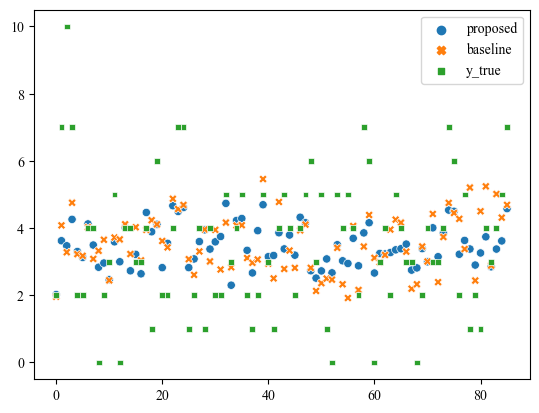

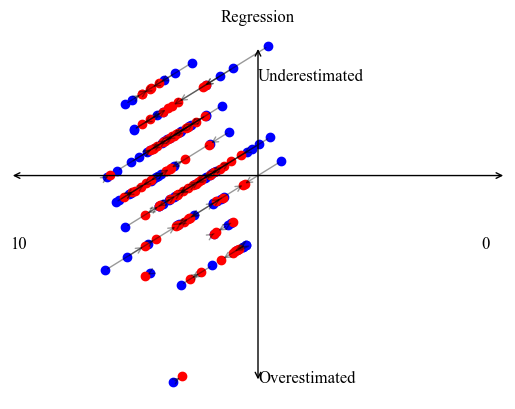

TypeError: cannot concatenate object of type '<class 'addict.addict.Dict'>'; only Series and DataFrame objs are valid

In [2]:

#%%
# =============================================================================
'''

    Analysis part

'''
# =============================================================================
# =============================================================================

'''

    Part 1: Check incorrect to correct and correct to incorrect

'''

if args.Print_Analysis_grp_Manual_select == True:
    count=0
    for exp_str in FeatureLabelMatch_manual:
        for lab_str in label_choose:
            exp_lst_str='::'.join([exp_str,lab_str])
            if count < len(FeatureLabelMatch_manual)/2:
                print("proposed_expstr='{}'".format(exp_lst_str))
            else:
                print("baseline_expstr='{}'".format(exp_lst_str))
            count+=1
'''

    Part 1: Check incorrect to correct and correct to incorrect

'''


proposed_expstr='static_feautre_LOC+dynamic_feature_LOC+dynamic_feature_phonation-LOC_columns+DEP_columns+LOCDEP_Trend_D_cols+LOCDEP_Syncrony_cols::ADOS_C'
# baseline_expstr='static_feautre_LOC+dynamic_feature_LOC+dynamic_feature_phonation-Phonation_Trend_K_cols::ADOS_C'
baseline_expstr='static_feautre_LOC+dynamic_feature_LOC+dynamic_feature_phonation-LOC_columns+DEP_columns::ADOS_C'
experiment_title='Regression'


proposed_featset_lst=proposed_expstr[re.search("-",proposed_expstr).end():re.search("::",proposed_expstr).start()].split("+")
baseline_featset_lst=baseline_expstr[re.search("-",baseline_expstr).end():re.search("::",baseline_expstr).start()].split("+")
Additional_featureSet=set(proposed_featset_lst) - set(baseline_featset_lst)
print("For Task", experiment_title, " additional feature sets are", Additional_featureSet)
if Session_level_all[proposed_expstr]['feattype'] == 'regression':
    SHAP_Inspect_logit=0
logit_number=SHAP_Inspect_logit



# =============================================================================
# Error type analyses
# =============================================================================
# df_compare_pair=pd.DataFrame(list())
Y_pred_lst=[
Session_level_all[proposed_expstr]['y_pred'],
Session_level_all[baseline_expstr]['y_pred'],
Session_level_all[proposed_expstr]['y_true'],
Session_level_all[proposed_expstr]['y_true'].index,
]

df_Y_pred=pd.DataFrame(Y_pred_lst[:-1],index=['proposed','baseline','y_true']).T
df_Y_pred_withName=pd.DataFrame(Y_pred_lst,index=['proposed','baseline','y_true','name']).T
df_Index2Name_mapping=df_Y_pred_withName['name']

# ASSERTION 確認沒有錯
def MSE_df(a,b):
    assert type(a) == type(b)
    if type(a)==pd.core.series.Series:
        return ((a - b)**2).mean()

# mse_proposed = ((df_Y_pred['proposed'] - df_Y_pred['y_true'])**2).mean()
# mse_baseline = ((df_Y_pred['baseline'] - df_Y_pred['y_true'])**2).mean()
mse_proposed = MSE_df(df_Y_pred['proposed'] , df_Y_pred['y_true'])
mse_baseline = MSE_df(df_Y_pred['baseline'] , df_Y_pred['y_true'])

print("The MSE of proposed model is: ", mse_proposed)
print("The MSE of baseline model is: ", mse_baseline)

# proposed的距離比baseline 的還要近
Improved=(df_Y_pred['y_true'] - df_Y_pred['proposed']).abs() < (df_Y_pred['y_true'] - df_Y_pred['baseline']).abs()
Degraded=(df_Y_pred['y_true'] - df_Y_pred['proposed']).abs() >= (df_Y_pred['y_true'] - df_Y_pred['baseline']).abs()


LargerVal= (df_Y_pred['proposed'] - df_Y_pred['baseline'])>0
LowerVal= (df_Y_pred['proposed'] - df_Y_pred['baseline'])<=0
ChangedPeople= LargerVal | LowerVal

quadrant1 = Degraded & LargerVal
quadrant2 = Improved & LargerVal
quadrant3 = Degraded & LowerVal
quadrant4 = Improved & LowerVal


baseline_ytrue_propose= ((df_Y_pred['baseline'] > df_Y_pred['y_true']) & (df_Y_pred['y_true'] > df_Y_pred['proposed'])) 
propose_ytrue_baseline= ((df_Y_pred['proposed'] > df_Y_pred['y_true']) & (df_Y_pred['y_true'] > df_Y_pred['baseline'])) 
inner = baseline_ytrue_propose | propose_ytrue_baseline

ytrue_lowest= (df_Y_pred['y_true'] - df_Y_pred['baseline']).abs() > (df_Y_pred['proposed'] - df_Y_pred['baseline']).abs()
ytrue_highest= (df_Y_pred['y_true'] - df_Y_pred['proposed']).abs() > (df_Y_pred['proposed'] - df_Y_pred['baseline']).abs()
outer = ytrue_lowest | ytrue_highest

assert (inner | outer).all()


Improved_indexes=list(df_Y_pred[Improved].index)
Degraded_indexes=list(df_Y_pred[Degraded].index)

LargerVal_indexes=list(df_Y_pred[LargerVal].index)
LowerVal_indexes=list(df_Y_pred[LowerVal].index)

quadrant1_indexes=list(df_Y_pred[quadrant1].index)
quadrant2_indexes=list(df_Y_pred[quadrant2].index)
quadrant3_indexes=list(df_Y_pred[quadrant3].index)
quadrant4_indexes=list(df_Y_pred[quadrant4].index)

# XXX

# y_hat^p - y > 0, y_hat^b - y > 0
global  Q1_idx
global  Q2_idx
global  Q3_idx
global  Q4_idx
Q1_idx=list(df_Y_pred[(df_Y_pred['proposed'] > df_Y_pred['y_true']) & (df_Y_pred['baseline'] > df_Y_pred['y_true'])].index)
# y_hat^p - y < 0, y_hat^b - y < 0
Q2_idx=list(df_Y_pred[(df_Y_pred['proposed'] < df_Y_pred['y_true']) & (df_Y_pred['baseline'] < df_Y_pred['y_true'])].index)
# y_hat^p - y > 0, y_hat^b - y < 0
Q3_idx=list(df_Y_pred[(df_Y_pred['proposed'] > df_Y_pred['y_true']) & (df_Y_pred['baseline'] < df_Y_pred['y_true'])].index)
# y_hat^p - y < 0, y_hat^b - y > 0
Q4_idx=list(df_Y_pred[(df_Y_pred['proposed'] < df_Y_pred['y_true']) & (df_Y_pred['baseline'] > df_Y_pred['y_true'])].index)

mae_proposed = MAE_df(df_Y_pred['proposed'] , df_Y_pred['y_true'])
mae_baseline = MAE_df(df_Y_pred['baseline'] , df_Y_pred['y_true'])

print("The MAE of proposed model is mae_proposed: ", mae_proposed)
print("The MAE of baseline model is mae_baseline: ", mae_baseline)


quadrant1_inner_indexes=list(df_Y_pred[quadrant1 & inner].index)
quadrant1_outer_indexes=list(df_Y_pred[quadrant1 & outer].index)
quadrant2_inner_indexes=list(df_Y_pred[quadrant2 & inner].index)
quadrant2_outer_indexes=list(df_Y_pred[quadrant2 & outer].index)
quadrant3_inner_indexes=list(df_Y_pred[quadrant3 & inner].index)
quadrant3_outer_indexes=list(df_Y_pred[quadrant3 & outer].index)
quadrant4_inner_indexes=list(df_Y_pred[quadrant4 & inner].index)
quadrant4_outer_indexes=list(df_Y_pred[quadrant4 & outer].index)


idxs_bag=[]
_bag=[]
for q in [1,2,3,4]:
    for side in ['inner','outer']:
        idxes_str='quadrant{q}_{side}_indexes'.format(q=q,side=side)
        idxs_bag+=vars()[idxes_str]
        _bag.append(idxes_str)
assert len(idxs_bag) == len(Improved_indexes+Degraded_indexes)

assert quadrant1_indexes == intersection(Degraded_indexes, LargerVal_indexes)
assert quadrant2_indexes == intersection(Improved_indexes, LargerVal_indexes)
assert quadrant3_indexes == intersection(Degraded_indexes, LowerVal_indexes)
assert quadrant4_indexes == intersection(Improved_indexes, LowerVal_indexes)



proposed_ypred_array=df_Y_pred['proposed'].values
baseline_ypred_array=df_Y_pred['baseline'].values

# 這邊計算出變高的人誤差修正（增加/減少）了多少，變低的人誤差修正（增加/減少）了多少
# 3.675 -> 3.167
for insp_instances_bool_str in ['LargerVal','LowerVal','ChangedPeople']:
    insp_instances_bool=vars()[insp_instances_bool_str]
    delta_proposed_diff_squared=(df_Y_pred[insp_instances_bool]['proposed'] - df_Y_pred[insp_instances_bool]['y_true'])**2
    delta_proposed_diff_MSE=delta_proposed_diff_squared.sum()/len(df_Y_pred)
    delta_baseline_diff_squared=(df_Y_pred[insp_instances_bool]['baseline'] - df_Y_pred[insp_instances_bool]['y_true'])**2
    delta_baseline_diff_MSE=delta_baseline_diff_squared.sum()/len(df_Y_pred)
    assert len(delta_proposed_diff_squared) == len(delta_baseline_diff_squared)
    print(insp_instances_bool_str,": have changed MSE",delta_proposed_diff_MSE-delta_baseline_diff_MSE)


# 這邊秀出proposed和baseline的實際改變
sns.scatterplot(data=df_Y_pred)

quadrant1_indexes=intersection(Degraded_indexes, LargerVal_indexes)
quadrant2_indexes=intersection(Improved_indexes, LargerVal_indexes)
quadrant3_indexes=intersection(Degraded_indexes, LowerVal_indexes)
quadrant4_indexes=intersection(Improved_indexes, LowerVal_indexes)


assert (sorted(quadrant1_indexes+quadrant2_indexes) == sorted(LargerVal_indexes))

assert len(Improved_indexes+Degraded_indexes) == len(LargerVal_indexes+LowerVal_indexes) 


'''

    Part 2: Check the SHAP values based on indexes in part 1
    
    先紀錄，再執行分析和畫圖

'''


def Organize_Needed_SHAP_info(Selected_indexes, Session_level_all, proposed_expstr, verbose=False):
    Selected_info_dict=Dict()
    for tst_idx in Selected_indexes:
        for key, values in Session_level_all[proposed_expstr]['SHAP_info'].items():
            test_fold_idx=[int(k) for k in key.split("_")]
            for i,ii in enumerate(test_fold_idx): #ii is the index of the sample, i is the position of this sample in this test fold
                if tst_idx == ii:
                    Selected_info_dict[tst_idx]['XTest']=values['XTest'].iloc[i,:]
                    Selected_info_dict[tst_idx]['explainer_expected_value']=values['explainer_expected_value']
                    shap_values_array=values['shap_values'][i,:].reshape(1,-1)
                    df_shap_values=pd.DataFrame(shap_values_array,columns=Selected_info_dict[tst_idx]['XTest'].index)
                    Selected_info_dict[tst_idx]['shap_values']=df_shap_values
                    if verbose == True:
                        print("testing sample ", ii, "is in the ", i, "position of test fold", key)
                    assert (Selected_info_dict[tst_idx]['XTest'] == Session_level_all[proposed_expstr]['X'].iloc[tst_idx]).all()
                    # print("It's feature value captured is", Selected_info_dict[tst_idx]['XTest'])
                    # print("It's original X value is", Session_level_all[proposed_expstr]['X'].iloc[tst_idx])
                    # print("See if they match")
    return Selected_info_dict

selected_idxs=LargerVal_indexes+LowerVal_indexes
Baseline_changed_info_dict=Organize_Needed_SHAP_info(selected_idxs, Session_level_all, baseline_expstr)
Proposed_changed_info_dict=Organize_Needed_SHAP_info(selected_idxs, Session_level_all, proposed_expstr)
Baseline_totalPoeple_info_dict=Organize_Needed_SHAP_info(df_Y_pred.index, Session_level_all, baseline_expstr)
Proposed_totalPoeple_info_dict=Organize_Needed_SHAP_info(df_Y_pred.index, Session_level_all, proposed_expstr)
#%%
# sellect_people_define=SellectP_define()
# 畫炫炮的錯誤型態分析 (Changed smaples的logit 1 decision function 的移動)
def Organize_Needed_decisionProb(Incorrect2Correct_indexes, df_Y_pred_withName, baseline_proposed_str='proposed'):
    decision_function_str='y_true'
    Incorrect2Correct_indexes=selected_idxs
    Incorrect2Correct_info_dict=Dict()
    for tst_idx in Incorrect2Correct_indexes:
        Incorrect2Correct_info_dict[tst_idx]['predictproba']=df_Y_pred_withName[baseline_proposed_str].loc[tst_idx]
        Incorrect2Correct_info_dict[tst_idx]['estimateError']=(df_Y_pred_withName[baseline_proposed_str].loc[tst_idx] - df_Y_pred_withName[decision_function_str].loc[tst_idx])

    return Incorrect2Correct_info_dict
# step 1: prepare data
selected_idxs=LargerVal_indexes+LowerVal_indexes

Baseline_changed_decision_info_dict=Organize_Needed_decisionProb(selected_idxs, df_Y_pred_withName, baseline_proposed_str='baseline')
Proposed_changed_decision_info_dict=Organize_Needed_decisionProb(selected_idxs, df_Y_pred_withName, baseline_proposed_str='proposed')
Baseline_total_decision_info_dict=Organize_Needed_decisionProb(df_Y_pred.index, df_Y_pred_withName, baseline_proposed_str='baseline')
Proposed_total_decision_info_dict=Organize_Needed_decisionProb(df_Y_pred.index, df_Y_pred_withName, baseline_proposed_str='proposed')


df_Proposed_changed_decision_info_dict=pd.DataFrame.from_dict(Proposed_changed_decision_info_dict,orient='index')
df_Baseline_changed_decision_info_dict=pd.DataFrame.from_dict(Baseline_changed_decision_info_dict,orient='index')
df_Proposed_total_decision_info_dict=pd.DataFrame.from_dict(Proposed_total_decision_info_dict,orient='index')
df_Baseline_total_decision_info_dict=pd.DataFrame.from_dict(Baseline_total_decision_info_dict,orient='index')
Sample_idxs_array=df_Baseline_changed_decision_info_dict.index.values





df_Y_true=df_Y_pred.loc[df_Baseline_changed_decision_info_dict.index]['y_true']

Incorrect_baseline=df_Y_pred['baseline'] != df_Y_pred['y_true']
Incorrect_proposed=df_Y_pred['proposed'] != df_Y_pred['y_true']
Correct_baseline=df_Y_pred['baseline'] != df_Y_pred['y_true']
Correct_proposed=df_Y_pred['proposed'] != df_Y_pred['y_true']

fig, ax = plt.subplots()

# decision function 負的表示predict logit 0, 正的表示logit 1
Baseline_x= df_Baseline_changed_decision_info_dict['predictproba'].values.copy()
# Baseline_y_decisionfunc= df_Baseline_changed_decision_info_dict['estimateError'].copy()
Baseline_y= df_Baseline_changed_decision_info_dict['estimateError'].values.copy()

Baseline_total_x= df_Baseline_total_decision_info_dict['predictproba'].values.copy()
# Baseline_total_y_decisionfunc= df_Baseline_total_decision_info_dict['estimateError'].copy()
Baseline_total_y= df_Baseline_total_decision_info_dict['estimateError'].values.copy()

# estimateError是正的y軸就是正的，estimateError bar是負的y軸就是負的
# Baseline_y[Improved_indexes.loc[df_Baseline_changed_decision_info_dict.index]]\
#     =Baseline_y_decisionfunc[Improved_indexes.loc[df_Baseline_changed_decision_info_dict.index]]
# Baseline_y[Degraded_indexes.loc[df_Baseline_changed_decision_info_dict.index]]\
#     =Baseline_y_decisionfunc[Degraded_indexes.loc[df_Baseline_changed_decision_info_dict.index]]
# Baseline_total_y[df_Baseline_total_decision_info_dict.loc[Incorrect_baseline]]\
#     =-df_Baseline_total_decision_info_dict.loc[Incorrect_baseline]
# Baseline_total_y[df_Baseline_total_decision_info_dict.loc[Incorrect_baseline]]\
#     =df_Baseline_total_decision_info_dict.loc[Correct_baseline]




Proposed_x= df_Proposed_changed_decision_info_dict['predictproba'].values.copy()
Proposed_y_decisionfunc= df_Proposed_changed_decision_info_dict['estimateError'].values.copy()
Proposed_y= df_Proposed_changed_decision_info_dict['estimateError'].values.copy()
Proposed_total_x= df_Proposed_total_decision_info_dict['predictproba'].values.copy()
Proposed_total_y_decisionfunc= df_Proposed_total_decision_info_dict['estimateError'].values.copy()
Proposed_total_y= df_Proposed_total_decision_info_dict['estimateError'].values.copy()



# Proposed_y[Improved_indexes.loc[df_Baseline_changed_decision_info_dict.index]]=\
#     Proposed_y_decisionfunc[Improved_indexes.loc[df_Baseline_changed_decision_info_dict.index]]
# Proposed_y[Degraded_indexes.loc[df_Baseline_changed_decision_info_dict.index]]=\
#     -Proposed_y_decisionfunc[Degraded_indexes.loc[df_Baseline_changed_decision_info_dict.index]]
# Proposed_total_y[df_Proposed_total_decision_info_dict.loc[Incorrect_proposed]]\
#     =-df_Proposed_total_decision_info_dict.loc[Incorrect_proposed]
# Proposed_total_y[df_Proposed_total_decision_info_dict.loc[Incorrect_proposed]]\
#     =df_Proposed_total_decision_info_dict.loc[Correct_proposed]

Total_y=list(Baseline_y)+list(Proposed_y)
Total_x=list(Baseline_x)+list(Proposed_x)

y_max=np.max(Total_y)
y_min=np.min(Total_y)
x_max=np.max(Total_x)
x_min=np.min(Total_x)
x_middle=(x_max+x_min)/2
y_middle=(y_max+y_min)/2

# ax.annotate("", xy=(起點x, 起點y), xytext=(終點x, 終點y),arrowprops=dict(arrowstyle="->"))
for B_x, B_y, P_x, P_y,idx in zip(Baseline_x,Baseline_y,Proposed_x,Proposed_y,Sample_idxs_array):
    ax.annotate("", xy=(B_x, B_y), xytext=(P_x, P_y),arrowprops=dict(arrowstyle="<-",alpha=.4))
    # ax.text((B_x+P_x)/2, (B_y+P_y)/2, str(idx), fontsize=12)
    # ax.text(B_x, B_y, str(idx), fontsize=12)
    # ax.text(P_x, P_y, str(idx), fontsize=12)

plt.scatter(Baseline_x, Baseline_y, c='b', alpha=1)
plt.scatter(Proposed_x, Proposed_y, c='r', alpha=1)


# plt.scatter(df_Baseline_total_decision_info_dict.predictproba, df_Baseline_total_decision_info_dict.abs().decisionfunc, c='b', alpha=.05)
# plt.scatter(df_Proposed_total_decision_info_dict.predictproba, df_Proposed_total_decision_info_dict.abs().decisionfunc, c='r', alpha=.05)
xmin_global, xmax_global=0, 10
xmiddle_global=(xmin_global+xmax_global)/2
ax.annotate('',xy=(xmin_global, 0), xytext=(xmax_global, 0),arrowprops=dict(arrowstyle="<->",alpha=1,))                                                                     
ax.annotate('',xy=(xmiddle_global, y_min), xytext=(xmiddle_global, y_max),arrowprops=dict(arrowstyle="<->",alpha=1,))
margin_y=(y_max-y_min)/10
margin_x=(xmax_global-xmin_global)/20

ax.text(xmin_global, y_middle-margin_y, '10', fontsize=12)
ax.text(xmax_global-margin_x, y_middle-margin_y, '0', fontsize=12)
    
ax.text(xmiddle_global, y_min, 'Overestimated', fontsize=12)
ax.text(xmiddle_global, y_max-margin_y, 'Underestimated', fontsize=12)   
fig.patch.set_visible(True)
ax.axis('off')
# plt.ylim(-1.5,1.5)
plt.xlim(0,10)
plt.title(experiment_title)
plt.show()
#%%
# 個體分析： 會存到SAHP_figures/{quadrant}/的資料夾，再開Jupyter去看
def Calculate_sum_of_SHAP_vals(df_values,FeatSel_module,FeatureSet_lst=['Phonation_Proximity_cols'],PprNmeMp=None):
    df_FeaSet_avg_Comparison=pd.DataFrame([],columns=FeatureSet_lst)
    for feat_set in FeatureSet_lst:
        feature_cols = getattr(FeatSel_module, feat_set)
        if PprNmeMp!=None:
            feature_cols=[ Swap2PaperName(name,PprNmeMp) for name in feature_cols]
        df_FeaSet_avg_Comparison[feat_set]=df_values.loc[feature_cols,:].sum()
    return df_FeaSet_avg_Comparison

SHAP_save_path_root="SAHP_figures/Regression/{quadrant}/"
shutil.rmtree(SHAP_save_path_root.format(quadrant=""), ignore_errors = True)

N=5
def Plot_FeatImportance_heatmap(df_table_info,outpath,N,M):
    df_table_info.index= [Swap2PaperName(idx, PprNmeMp) for idx in df_table_info.index]
    df_sorted_shapVals=pd.DataFrame()
    df_sorted_featIdxs=pd.DataFrame()
    for col in df_table_info.columns:
        df_vals=pd.DataFrame(df_table_info[col].sort_values().values,index=range(len(df_table_info[col])),columns=[col])
        df_features=pd.DataFrame(df_table_info[col].sort_values().index,index=range(len(df_table_info[col])),columns=[col])
        df_sorted_shapVals=pd.concat([df_sorted_shapVals,df_vals],axis=1)
        df_sorted_featIdxs=pd.concat([df_sorted_featIdxs,df_features],axis=1)
        
    df=df_sorted_shapVals.copy()
    
    Idxes_array=df_sorted_featIdxs.values
    vals = np.around(df.values,2)
    
    norm = plt.Normalize(vals.min()-1, vals.max()+1)
    colours = plt.cm.hot(norm(vals))
    
    fig = plt.figure(figsize=(7*M,8))
    ax = fig.add_subplot(111, frameon=True, xticks=[], yticks=[])
    
    colWidth=0.03 if M > 5 else 0.5
    
    # Lowest N samples !!!! 注意 這個排序是從小排到大
    the_table=plt.table(cellText=Idxes_array[:N,:M], rowLabels=df.index[:N], colLabels=df.columns[:M], 
                        colWidths = [colWidth]*vals[:N,:M].shape[1], loc='center', 
                        cellColours=colours[:N,:M])
    the_table.set_fontsize(12)
    the_table.scale(1, 1)
    # plt.show()    
    # print(Idxes_array[:N,:M])
    plt.savefig('{outpath}_Low5.png'.format(outpath=outpath))
    
    # Lowest N samples
    the_table=plt.table(cellText=Idxes_array[-N:,:M], rowLabels=df.index[-N:], colLabels=df.columns[:M], 
                        colWidths = [colWidth]*vals[-N:,:M].shape[1], loc='center', 
                        cellColours=colours[-N:,:M])
    the_table.set_fontsize(12)
    the_table.scale(1, 1)
    # plt.show()    
    # print(Idxes_array[:N,:M])
    plt.savefig('{outpath}_Top5.png'.format(outpath=outpath))
    
# =============================================================================
Inspect_info_dict_str='Proposed_changed_info_dict'
# Inspect_info_dict_str='Baseline_changed_info_dict'
Inspect_info_dict=vars()[Inspect_info_dict_str]

Top_featureSet_lst_dict={}
Top_featureSet_lst_dict['Proposed_changed_info_dict']=proposed_featset_lst
Top_featureSet_lst_dict['Baseline_changed_info_dict']=baseline_featset_lst
# =============================================================================
# expected_value_lst=[]
UsePaperName_bool=True

Quadrant_FeatureImportance_dict={}
Quadrant_feature_AddedTopFive_dict={}
Quadrant_feature_AddedFeatureImportance_dict={}
Quadrant_Sumedfeature_AddedFeatureImportance_sorted_dict={}
Quadrant_Singlefeature_AddedFeatureImportance_sorted_dict={}
# for Analysis_grp_str in ['Manual_inspect_idxs','quadrant1_indexes','quadrant2_indexes','quadrant3_indexes','quadrant4_indexes']:
for Analysis_grp_str in ['quadrant1_indexes','quadrant2_indexes','quadrant3_indexes','quadrant4_indexes']:
# for Analysis_grp_str in ['quadrant1_inner_indexes','quadrant1_outer_indexes','quadrant2_inner_indexes','quadrant2_outer_indexes','quadrant3_inner_indexes','quadrant3_outer_indexes','quadrant4_inner_indexes','quadrant4_outer_indexes']:    
# for Analysis_grp_str in ['LargerVal_indexes','LowerVal_indexes']:
# for Analysis_grp_str in ['Improved_indexes','Degraded_indexes']:
    Analysis_grp_indexes=vars()[Analysis_grp_str]
    df_shap_values_stacked=pd.DataFrame([])
    Xtest_dict={}
    expected_value_lst=[]    
    for Inspect_samp in Analysis_grp_indexes:
        shap_info=Inspect_info_dict[Inspect_samp]
        
        expected_value=shap_info['explainer_expected_value']
        shap_values=shap_info['shap_values'].values
        df_shap_values=shap_info['shap_values']
        df_shap_values.index=[Inspect_samp]
        
        df_shap_values_T=df_shap_values.T
        
        Xtest=shap_info['XTest']
        
        Xtest_dict[Inspect_samp]=Xtest
        df_shap_values_stacked=pd.concat([df_shap_values_stacked,df_shap_values],)
        expected_value_lst.append(expected_value)
        
        
        Xtest.index=[ Swap2PaperName(name,PprNmeMp) for name in Xtest.index]
        # shap.force_plot(expected_value, df_shap_values.values, Xtest.T, matplotlib=True,show=False)
        df_shap_avgvalues=Calculate_sum_of_SHAP_vals(df_shap_values.T,\
                                                    FeatSel_module=FeatSel,\
                                                    FeatureSet_lst=Top_featureSet_lst_dict[Inspect_info_dict_str],)
        df_avg_Xtest=Calculate_sum_of_SHAP_vals(pd.DataFrame(Xtest.values, index=Xtest.index),\
                                                FeatSel_module=FeatSel,\
                                                FeatureSet_lst=Top_featureSet_lst_dict[Inspect_info_dict_str],\
                                                PprNmeMp=PprNmeMp)
        
        p=shap.force_plot(expected_value, df_shap_avgvalues.values, df_avg_Xtest)
        # p=shap.force_plot(expected_value, df_shap_values.values, Xtest.T)
        
        
        SHAP_save_path=SHAP_save_path_root.format(quadrant='{0}_{1}'.format(Inspect_info_dict_str.split("_")[0],Analysis_grp_str))
        # SHAP_save_path=SHAP_save_path_root.format(quadrant=Analysis_grp_str)
        if not os.path.exists(SHAP_save_path):
            os.makedirs(SHAP_save_path)
            
        shap.save_html(SHAP_save_path+'{sample}.html'.format(sample=Inspect_samp), p)
        
        if Inspect_info_dict_str == 'Baseline_changed_info_dict':
            Inspect_featureSet=set(Top_featureSet_lst_dict[Inspect_info_dict_str])
        elif Inspect_info_dict_str == 'Proposed_changed_info_dict':
            Inspect_featureSet=Additional_featureSet
        Lists_of_addedFeatures=[getattr(FeatSel,k)  for k in Inspect_featureSet]
        Lists_of_addedFeatures_flatten=[e for ee in Lists_of_addedFeatures for e in ee]
        df_FeatureImportance_AddedFeatures=df_shap_values[Lists_of_addedFeatures_flatten].T
        df_FeatureImportance_AddedFeatures_absSorted=df_FeatureImportance_AddedFeatures.abs()[Inspect_samp].sort_values(ascending=False)
        
        
        
        df_addedFeatures_TopN=df_FeatureImportance_AddedFeatures.loc[df_FeatureImportance_AddedFeatures_absSorted.head(N).index]
        # Quadrant_feature_AddedTopFive_dict[Inspect_samp]=df_addedFeatures_TopN
        Quadrant_feature_AddedFeatureImportance_dict[Inspect_samp]=df_FeatureImportance_AddedFeatures[Inspect_samp].sort_values(ascending=False)
        
        
        
    if not (len(df_shap_values_stacked) == 0 and  len(Xtest_dict)==0):
        df_XTest_stacked=pd.DataFrame.from_dict(Xtest_dict).T
        assert (df_XTest_stacked.index == df_shap_values_stacked.index).all()
        
        df_FeaSet_avg_Comparison_proposed=Calculate_sum_of_SHAP_vals(df_shap_values_stacked.T,\
                                                                     FeatSel_module=FeatSel,\
                                                                     FeatureSet_lst=Top_featureSet_lst_dict[Inspect_info_dict_str],)
                                                                     # PprNmeMp=PprNmeMp)
        df_FeaAvg=df_FeaSet_avg_Comparison_proposed.copy()
        df_XTest_stacked_proposed=Calculate_sum_of_SHAP_vals(df_XTest_stacked.T,\
                                                                     FeatSel_module=FeatSel,\
                                                                     FeatureSet_lst=Top_featureSet_lst_dict[Inspect_info_dict_str],
                                                                     PprNmeMp=PprNmeMp)
        Quadrant_Sumedfeature_AddedFeatureImportance_sorted_dict[Analysis_grp_str]=df_FeaAvg.sort_values(list(df_FeaAvg.columns),\
                                                                                                        ascending=[False]*len(df_FeaAvg.columns))
        Quadrant_Singlefeature_AddedFeatureImportance_sorted_dict[Analysis_grp_str]=df_shap_values_stacked.sort_values(list(df_shap_values_stacked.columns),\
                                                                                                        ascending=[False]*len(df_shap_values_stacked.columns))
            
        df_table_info = Quadrant_Singlefeature_AddedFeatureImportance_sorted_dict[Analysis_grp_str].T
        # [tmp] need remove soon
        # Analysis_grp_str='quadrant4_outer_indexes'
        # df_tmp_AAAbbb = Quadrant_Singlefeature_AddedFeatureImportance_sorted_dict[Analysis_grp_str].T
        # df_tmp_AAAbbbC= df_tmp_AAAbbb[[78, 13, 71, 76]]
        # 
        # clustering
        # //////////////////////////////////////////
        # df_tocluster=df_FeaAvg.copy()
        # # df_tocluster=df_shap_values_stacked.copy()
        # D = scipy.spatial.distance.pdist(df_tocluster.loc[:,:], 'sqeuclidean')
        # Z = scipy.cluster.hierarchy.complete(D)
        # plt.figure()
        # dn = scipy.cluster.hierarchy.dendrogram(Z)
        # plt.show()
        # clustOrder = scipy.cluster.hierarchy.leaves_list(Z)
        # df_tocluster.iloc[dn['leaves']].index
        # df_tocluster.iloc[clustOrder].index
        # //////////////////////////////////////////
        
        # p=shap.force_plot(np.mean(expected_value_lst),df_shap_values_stacked.values, df_XTest_stacked)
        p=shap.force_plot(np.mean(expected_value_lst),df_FeaSet_avg_Comparison_proposed.values, df_XTest_stacked_proposed)
        # shap_explanation=shap.Explanation(df_shap_values_stacked)
        
        SHAP_save_path="SAHP_figures/Regression/Stacked/"
        if not os.path.exists(SHAP_save_path):
            os.makedirs(SHAP_save_path)
        shap.save_html(SHAP_save_path+'{sample}.html'.format(sample=Analysis_grp_str), p)
        Plot_FeatImportance_heatmap(df_table_info,outpath=SHAP_save_path+'{sample}'.format(sample=Analysis_grp_str),N=5,M=len(df_table_info.columns))


#%%
# # 以feature set為單位畫summary plot
# def ReorganizeFeatures4SummaryPlot(shap_values_logit, df_XTest,FeatureSet_lst=None,Featurechoose_lst=None):
#     # step1 convert shapvalue to df_shapvalues
#     df_shap_values=pd.DataFrame(shap_values_logit,columns=df_XTest.columns)
#     # step2 Categorize according to FeatureSet_lst
#     df_Reorganized_shap_values=pd.DataFrame()
#     df_Reorganized_XTest=pd.DataFrame()
#     if FeatureSet_lst!=None:
#         for FSL in FeatureSet_lst:
#             FSL_papercolumns=[Swap2PaperName(k,PprNmeMp) for k in FeatSel.CategoricalName2cols[FSL]]
        
#             df_Reorganized_shap_values=pd.concat([df_Reorganized_shap_values,df_shap_values[FSL_papercolumns]],axis=1)
#             df_Reorganized_XTest=pd.concat([df_Reorganized_XTest,df_XTest[FSL_papercolumns]],axis=1)
#     elif Featurechoose_lst!=None:
#         FSL_papercolumns=[Swap2PaperName(k,PprNmeMp) for k in Featurechoose_lst]
#         df_Reorganized_shap_values=df_shap_values[FSL_papercolumns]
#         df_Reorganized_XTest=df_XTest[FSL_papercolumns]

#     assert df_Reorganized_shap_values.shape == df_Reorganized_XTest.shape
#     return df_Reorganized_shap_values.values, df_Reorganized_XTest

# shap_values, df_XTest, keys=Prepare_data_for_summaryPlot_regression(Proposed_totalPoeple_info_dict,\
#                                                           PprNmeMp=PprNmeMp)
# # df_Reorganized_shap_values=ReorganizeFeatures4SummaryPlot(shap_values, df_XTest)
# df_shap_values=pd.DataFrame(shap_values,columns=df_XTest.columns)




#%%
# =============================================================================
'''

    manual area

'''
# Top_featureSet_lst_dict['Proposed_changed_info_dict']

# 調查Improved 的那個種類
df_conclusion_record=pd.DataFrame()
for FeatSet in Top_featureSet_lst_dict[Inspect_info_dict_str]:
    quadrant2_shap=Quadrant_Sumedfeature_AddedFeatureImportance_sorted_dict['quadrant2_indexes'][FeatSet]
    quadrant2_helped= quadrant2_shap [quadrant2_shap > 0]
    print(FeatSet," :helped quadrant2 samples length:: ",len(quadrant2_helped))
    
    
    quadrant4_shap=Quadrant_Sumedfeature_AddedFeatureImportance_sorted_dict['quadrant4_indexes'][FeatSet]
    quadrant4_helped= quadrant4_shap [quadrant4_shap < 0]
    print(FeatSet," :helped quadrant4 samples length:: ",len(quadrant4_helped))

    # =========================================================================

    quadrant1_shap=Quadrant_Sumedfeature_AddedFeatureImportance_sorted_dict['quadrant1_indexes'][FeatSet]
    quadrant1_degraded= quadrant1_shap [quadrant1_shap > 0]
    print(FeatSet," :degraded quadrant1 samples length:: ",len(quadrant1_degraded))
    
    
    quadrant3_shap=Quadrant_Sumedfeature_AddedFeatureImportance_sorted_dict['quadrant3_indexes'][FeatSet]
    quadrant3_degraded= quadrant3_shap [quadrant3_shap < 0]
    print(FeatSet," :degraded quadrant1 samples length:: ",len(quadrant1_degraded))
    
    df_conclusion_record.loc[FeatSet, 'quadrant2_helpedSamples']=len(quadrant2_helped)
    df_conclusion_record.loc[FeatSet, 'quadrant2_helpedlevel']=quadrant2_helped.sum()
    df_conclusion_record.loc[FeatSet, 'quadrant4_helpedSamples']=len(quadrant4_helped)
    df_conclusion_record.loc[FeatSet, 'quadrant4_helpedlevel']=quadrant4_helped.sum()
    
    df_conclusion_record.loc[FeatSet, 'quadrant1_degradedSamples']=len(quadrant1_degraded)
    df_conclusion_record.loc[FeatSet, 'quadrant1_degradedlevel']=quadrant1_degraded.sum()
    df_conclusion_record.loc[FeatSet, 'quadrant3_degradedSamples']=len(quadrant3_degraded)
    df_conclusion_record.loc[FeatSet, 'quadrant3_degradedlevel']=quadrant3_degraded.sum()
Quadrant_Sumedfeature_AddedFeatureImportance_sorted_dict['quadrant4_indexes']
# =============================================================================


#%%
# Feature set combination: Inter-VD+FD+GC[VSC]\textsubscript{inv}+Syncrony[VSC] 的summary plot
def Prepare_data_for_summaryPlot_regression(SHAPval_info_dict, feature_columns=None,PprNmeMp=None):
    keys_bag=[]
    XTest_dict={}
    shap_values_0_bag=[]
    for people in sorted(SHAPval_info_dict.keys()):
        keys_bag.append(people)
        if not feature_columns == None:
            df_=SHAPval_info_dict[people]['XTest'][feature_columns]
            df_shape_value=SHAPval_info_dict[people]['shap_values'][feature_columns]
        else:
            df_=SHAPval_info_dict[people]['XTest']
            df_shape_value=SHAPval_info_dict[people]['shap_values']
        # if not SumCategorical_feats == None:
        #     for k,values in SumCategorical_feats.items():
        #         df_[k]=df_.loc[values].sum()
        XTest_dict[people]=df_        
        shap_values_0_bag.append(df_shape_value.loc[0].values)
    shap_values_0_array=np.vstack(shap_values_0_bag)
    shap_values=shap_values_0_array
    df_XTest=pd.DataFrame.from_dict(XTest_dict,orient='columns').T
    if PprNmeMp!=None:
        df_XTest.columns=[Swap2PaperName(k,PprNmeMp) for k in df_XTest.columns]
    return shap_values, df_XTest, keys_bag

# inspect_featuresets='Trend[LOCDEP]_d'  #Trend[LOCDEP]d + Proximity[phonation]
# inspect_featuresets='LOC_columns'  #LOC_columns + Syncrony[phonation]
# inspect_featuresets_lst=['LOC_columns','DEP_columns','Trend[LOCDEP]_d','Trend[LOCDEP]_k','Syncrony[LOCDEP]']



inspect_featuresets_lst=list(Additional_featureSet)
featuresetsListTotal_lst=[]
for inspect_featuresets in inspect_featuresets_lst:
    # featuresetsListTotal_lst+=FeatSel.CategoricalName2cols[inspect_featuresets]
    featuresetsListTotal_lst+=getattr(FeatSel,inspect_featuresets)
shap_values, df_XTest, keys=Prepare_data_for_summaryPlot_regression(Proposed_totalPoeple_info_dict,\
                                                          feature_columns=featuresetsListTotal_lst,\
                                                          PprNmeMp=PprNmeMp)
# Col2Delete=""
Col2Delete="GC[BCC]$_\mathrm{inv}$"
if len(Col2Delete) > 0:
    Colidx2Delete=[list(df_XTest.columns).index(Col2Delete)]
else:
    Colidx2Delete=[]

# TASLP 跑Fig.5 圖片的時候會用到
max_display=14
if len(Colidx2Delete)>0:
    shap.summary_plot(np.delete(shap_values,obj=Colidx2Delete,axis=1), df_XTest.drop(columns=Col2Delete),feature_names=df_XTest.drop(columns=Col2Delete).columns, \
                      max_display=max_display,\
                      axis_color='black',\
                      
                      show=False
                      )
    plt.gcf().axes[-1].set_aspect(100)
    plt.gcf().axes[-1].set_box_aspect(100)
    # plt.gcf().axes[-1].set_aspect('auto')
    # plt.colorbar()
    fig = plt.gcf()
    fig.set_size_inches((4,5))
    plt.title("Task: prediction of ADOS$_\mathrm{comm}$",fontsize=15)
    fig.savefig('images/SHAP_RegressionTask.png',format = "png",dpi = 300,bbox_inches = 'tight')
else:
    shap.summary_plot(shap_values, df_XTest,feature_names=df_XTest.columns,show=False, max_display=max_display)
plt.title(experiment_title)
plt.show()

# 製造 importance plot
# shap.summary_plot(shap_values, df_XTest,feature_names=df_XTest.columns,show=False, plot_type='bar', max_display=17)
# plt.title(experiment_title)
# plt.show()

# 觀察Feature值跟SHAP value的correlation
df_Pcorrela_FeaturesnSHAPVal=Calculate_XTestShape_correlation(Proposed_totalPoeple_info_dict,logit_number=logit_number)

df_X_featureRank=pd.DataFrame()
for col in df_XTest.columns:
    
    df_rank_features=df_XTest[col].argsort()  #從小排到大
    df_rank=pd.Series(df_rank_features.index.values, index=df_rank_features ,name=df_rank_features.name).sort_index()
    
    df_X_featureRank=pd.concat([df_X_featureRank,df_rank],axis=1)
    df_X_featureRank_T=df_X_featureRank.T
    # if col == '$BCC$':
    #     aaa=ccc
#%%
# XXX Feature sets Inter-VD, FD, GC[VSC]\textsubscript{inv}, Syncrony[VSC] 的summary plot

def ReorganizeFeatures4SummaryPlot(shap_values_logit, df_XTest,FeatureSet_lst=None,Featurechoose_lst=None):
    # 就按照指定的順序放feature
    # step1 convert shapvalue to df_shapvalues
    df_shap_values=pd.DataFrame(shap_values_logit,columns=df_XTest.columns)
    # step2 Categorize according to FeatureSet_lst
    df_Reorganized_shap_values=pd.DataFrame()
    df_Reorganized_XTest=pd.DataFrame()
    if FeatureSet_lst!=None:
        for FSL in FeatureSet_lst:
            FSL_papercolumns=[Swap2PaperName(k,PprNmeMp) for k in FeatSel.CategoricalName2cols[FSL]]
        
            df_Reorganized_shap_values=pd.concat([df_Reorganized_shap_values,df_shap_values[FSL_papercolumns]],axis=1)
            df_Reorganized_XTest=pd.concat([df_Reorganized_XTest,df_XTest[FSL_papercolumns]],axis=1)
    elif Featurechoose_lst!=None:
        FSL_papercolumns=[Swap2PaperName(k,PprNmeMp) for k in Featurechoose_lst]
        df_Reorganized_shap_values=df_shap_values[FSL_papercolumns]
        df_Reorganized_XTest=df_XTest[FSL_papercolumns]

    assert df_Reorganized_shap_values.shape == df_Reorganized_XTest.shape
    return df_Reorganized_shap_values.values, df_Reorganized_XTest

FeatureSet_lst=['Vowel_dispersion_inter__vowel_centralization','Vowel_dispersion_inter__vowel_dispersion',#LOC_columns
                'formant_dependency',#DEP_columns
                'Trend[Vowel_dispersion_inter__vowel_centralization]_d','Trend[Vowel_dispersion_inter__vowel_dispersion]_d','Trend[Vowel_dispersion_intra]_d','Trend[formant_dependency]_d',#Trend[LOCDEP]_d
                'Trend[Vowel_dispersion_inter__vowel_centralization]_k','Trend[Vowel_dispersion_inter__vowel_dispersion]_k','Trend[Vowel_dispersion_intra]_k','Trend[formant_dependency]_k',#Trend[LOCDEP]_k
                'Syncrony[Vowel_dispersion_inter__vowel_centralization]','Syncrony[Vowel_dispersion_inter__vowel_dispersion]','Syncrony[Vowel_dispersion_intra]','Syncrony[formant_dependency]',#Syncrony[LOCDEP]
                ]

FeatureChoose_lst=[
    'FCR2',
    '$Wilks$',
    'VSA2',
    '$BCC$',
    '$BCV$',
    '$Pillai$',
    '$Hotel$',
    '$Roys$',
    '$Det(W^{-1}B)$',
    '$Tr(W^{-1}B)$',
    'pear_12',
    'spear_12',
    'kendall_12',
    'dcorr_12',
    # 'Proximity[dcorr_12]',
    # 'Convergence[pear_12',
    # 'Convergence[dcorr_12]',
    ]
FeatureSet_lst=['LOC_columns','DEP_columns','LOCDEP_Syncrony_cols','LOCDEP_Trend_D_cols']
for FSL in FeatureSet_lst:
    print(FeatSel.CategoricalName2cols[FSL])



# 第一個分析，Inter-VD+GC[P]\textsubscript{inv}+GC[P]\textsubscript{part}+Syncrony[P] 的 SHAP分析
###############################################################################
proposed_expstr='static_feautre_LOC+dynamic_feature_LOC+dynamic_feature_phonation-LOC_columns+DEP_columns+LOCDEP_Trend_D_cols+LOCDEP_Syncrony_cols::ADOS_C'
Proposed_changed_info_dict=Organize_Needed_SHAP_info(selected_idxs, Session_level_all, proposed_expstr)
shap_values, df_XTest, keys=Prepare_data_for_summaryPlot_regression(Proposed_changed_info_dict,\
                                                          PprNmeMp=PprNmeMp)

# Reorganized_shap_values, df_Reorganized_XTest=ReorganizeFeatures4SummaryPlot(shap_values, df_XTest, Featurechoose_lst=FeatureChoose_lst)
# Reorganized_shap_values, df_Reorganized_XTest=ReorganizeFeatures4SummaryPlot(shap_values, df_XTest, \
#                     FeatureSet_lst=['LOC_columns','DEP_columns','LOCDEP_Trend_D_cols','LOCDEP_Syncrony_cols'])
Reorganized_shap_values, df_Reorganized_XTest=ReorganizeFeatures4SummaryPlot(shap_values, df_XTest, \
                    FeatureSet_lst=['DEP_columns'])
shap.summary_plot(Reorganized_shap_values, df_Reorganized_XTest,show=False, max_display=len(df_XTest.columns),sort=False)

plt.title(experiment_title)
fig = plt.gcf()
plt.gcf().axes[-1].set_aspect(100)
plt.gcf().axes[-1].set_box_aspect(20)
plt.gcf().axes[-1].set_aspect('auto')
# plt.colorbar()
fig = plt.gcf()
fig.set_size_inches((4,1.5))
fig.savefig('images/SHAP_RegressionTask.png',format = "png",dpi = 300,bbox_inches = 'tight')
plt.close(fig)


# Exp_str_lst=[
# 'static_feautre_LOC+dynamic_feature_LOC+dynamic_feature_phonation-LOC_columns::ADOS_C',
# 'static_feautre_LOC+dynamic_feature_LOC+dynamic_feature_phonation-DEP_columns::ADOS_C',
# 'static_feautre_LOC+dynamic_feature_LOC+dynamic_feature_phonation-LOCDEP_Trend_D_cols::ADOS_C',
# 'static_feautre_LOC+dynamic_feature_LOC+dynamic_feature_phonation-LOCDEP_Syncrony_cols::ADOS_C',]

# Exp_strs='static_feautre_LOC+dynamic_feature_LOC+dynamic_feature_phonation-LOC_columns::ADOS_C'


# def ExportSummaryImages(Exp_strs,Session_level_all):
#     FeatSet=Exp_strs[re.search("-",Exp_strs).end():re.search("::",Exp_strs).start()]
#     changed_info_dict=Organize_Needed_SHAP_info(selected_idxs, Session_level_all, Exp_strs)
#     shap_values, df_XTest, keys=Prepare_data_for_summaryPlot_regression(changed_info_dict,\
#                                                               feature_columns=getattr(FeatSel,FeatSet),\
#                                                               PprNmeMp=PprNmeMp)
    
#     Reorganized_shap_values, Reorganized_df_XTest=ReorganizeFeatures4SummaryPlot(shap_values, df_XTest, FeatureSet_lst=[FeatSet])
#     shap.summary_plot(Reorganized_shap_values, Reorganized_df_XTest,show=False, max_display=len(Reorganized_df_XTest.columns),sort=False)
    
#     # plt.title(experiment_title)
#     fig = plt.gcf()
#     fig.savefig('images/SHAP_RegressionTask_{}.png'.format(FeatSet),format = "png",dpi = 300,bbox_inches = 'tight')
#     plt.close(fig)

# proposed_expstr

# ExportSummaryImages(proposed_expstr,Session_level_all)
# for Exp_strs in Exp_str_lst:
#     ExportSummaryImages(Exp_strs,Session_level_all)

    
#%%
# 第二個分析GC[P]\textsubscript{part}+Syncrony[P]是幫助到哪幾個quadrant
PprNme2OriginNme={
    'InterVD':'LOC_columns',
    'FD':'DEP_columns',
    'GCVSCinv':'LOCDEP_Trend_D_cols',
    'SynchronyVSC':'LOCDEP_Syncrony_cols',
    }


FeatSetLst=['InterVD','FD','GCVSCinv','SynchronyVSC']
def featureSetSHAPVal(df_shap_values, FeatSel , FeatSetLst=['InterVD','FD','GCVSCinv','SynchronyVSC']):
    InterVD=[Swap2PaperName(e, PprNmeMp) for e in FeatSel.LOC_columns]
    FD=[Swap2PaperName(e, PprNmeMp) for e in FeatSel.DEP_columns]
    GCVSCinv=[Swap2PaperName(e, PprNmeMp) for e in FeatSel.LOCDEP_Trend_D_cols]
    SynchronyVSC=[Swap2PaperName(e, PprNmeMp) for e in FeatSel.LOCDEP_Syncrony_cols]
    df_shap_sum_dict={}
    for FS in FeatSetLst:
        df_shap_sum_dict[FS]=df_shap_values[vars()[FS]].sum(axis=1)
    return df_shap_sum_dict  



proposed_expstr='static_feautre_LOC+dynamic_feature_LOC+dynamic_feature_phonation-LOC_columns+DEP_columns+LOCDEP_Trend_D_cols+LOCDEP_Syncrony_cols::ADOS_C'
baseline_expstr='static_feautre_LOC+dynamic_feature_LOC+dynamic_feature_phonation-LOC_columns+DEP_columns::ADOS_C'
Proposed_changed_info_dict=Organize_Needed_SHAP_info(selected_idxs, Session_level_all, proposed_expstr)
Baseline_changed_info_dict=Organize_Needed_SHAP_info(selected_idxs, Session_level_all, baseline_expstr)
def GetdfSHAPSUMdict(Proposed_changed_info_dict, FeatSetLst):
    featuresetsListTotal_lst=[]
    for inspect_featuresets in FeatSetLst:
        featuresetsListTotal_lst+=getattr(FeatSel,PprNme2OriginNme[inspect_featuresets])
     
    shap_values, df_XTest, keys=Prepare_data_for_summaryPlot_regression(Proposed_changed_info_dict,\
                                                              feature_columns=featuresetsListTotal_lst,\
                                                              PprNmeMp=PprNmeMp)
    BaseVal_dict={}
    for key, value in Proposed_changed_info_dict.items():
        BaseVal_dict[key]=value.explainer_expected_value
    df_BaseVal=pd.DataFrame.from_dict(BaseVal_dict,orient='index').sort_index().squeeze()  # 轉成Series
      
    df_shap_values=pd.DataFrame(shap_values,columns=df_XTest.columns)
    # 先把同個feature set的shap values加總
    
    df_shap_sum_dict=featureSetSHAPVal(df_shap_values,FeatSel,FeatSetLst)
    df_shap_sum_dict['baseval']=df_BaseVal
    return df_shap_sum_dict
proposed_shap_sum_dict=GetdfSHAPSUMdict(Proposed_changed_info_dict, FeatSetLst=['InterVD', 'FD', 'GCVSCinv', 'SynchronyVSC'])
baseline_shap_sum_dict=GetdfSHAPSUMdict(Baseline_changed_info_dict, FeatSetLst=['InterVD', 'FD'])
# for key in proposed_shap_sum_dict.keys(): # 就確認沒錯做而已，可刪
#     assert (proposed_shap_sum_dict[key] - df_shap_sum_dict_copy[key]).sum()==0

DELTAshap_sum_dict={}
for key in proposed_shap_sum_dict.keys():
    if key in baseline_shap_sum_dict.keys():
        DELTAshap_sum_dict[key]=proposed_shap_sum_dict[key]-baseline_shap_sum_dict[key]
    else:
        DELTAshap_sum_dict[key]=proposed_shap_sum_dict[key]-pd.Series(np.zeros(len(proposed_shap_sum_dict[key])))


additionSets=set(['InterVD', 'FD', 'GCVSCinv', 'SynchronyVSC']) - set(['InterVD', 'FD'])
for S in additionSets:
    assert (DELTAshap_sum_dict[S] == proposed_shap_sum_dict[S]).all()


# quadrant1 = Degraded & LargerVal
# quadrant2 = Improved & LargerVal
# quadrant3 = Degraded & LowerVal
# quadrant4 = Improved & LowerVal

# Improved_indexes=list(df_Y_pred[Improved].index)
# Degraded_indexes=list(df_Y_pred[Degraded].index)
# LargerVal_indexes=list(df_Y_pred[LargerVal].index)
# LowerVal_indexes=list(df_Y_pred[LowerVal].index)

# quadrant1_indexes=list(df_Y_pred[quadrant1].index)
# quadrant2_indexes=list(df_Y_pred[quadrant2].index)
# quadrant3_indexes=list(df_Y_pred[quadrant3].index)
# quadrant4_indexes=list(df_Y_pred[quadrant4].index)
MSE_Q1=MSE_df(df_Y_pred['proposed'][Q1_idx], df_Y_pred['y_true'][Q1_idx])
MSE_Q2=MSE_df(df_Y_pred['proposed'][Q2_idx], df_Y_pred['y_true'][Q2_idx])
MSE_Q3=MSE_df(df_Y_pred['proposed'][Q3_idx], df_Y_pred['y_true'][Q3_idx])
MSE_Q4=MSE_df(df_Y_pred['proposed'][Q4_idx], df_Y_pred['y_true'][Q4_idx])
MSE_all=MSE_df(df_Y_pred['proposed'], df_Y_pred['y_true'])

def square_Err(a,b):
    assert type(a) == type(b)
    if type(a)==pd.core.series.Series:
        return ((a - b)**2).sum()
SE_Q1=square_Err(df_Y_pred['proposed'][Q1_idx], df_Y_pred['y_true'][Q1_idx])
SE_Q2=square_Err(df_Y_pred['proposed'][Q2_idx], df_Y_pred['y_true'][Q2_idx])
SE_Q3=square_Err(df_Y_pred['proposed'][Q3_idx], df_Y_pred['y_true'][Q3_idx])
SE_Q4=square_Err(df_Y_pred['proposed'][Q4_idx], df_Y_pred['y_true'][Q4_idx])

SE_all=square_Err(df_Y_pred['proposed'], df_Y_pred['y_true'])    

print("sigma_MSE(Qs) {} = MSE_all {}".format(sum([MSE_Q1,MSE_Q2,MSE_Q3,MSE_Q4]),MSE_all))
print("sigma_SE(Qs) {} = SE_all {}".format(sum([SE_Q1,SE_Q2,SE_Q3,SE_Q4]),SE_all))

round_number=6
delta_group=['Δbaseval','ΔInterVD','ΔFD','ΔGCVSCinv','ΔSynchronyVSC']
# proposed_group=['P_baseval','P_InterVD','P_FD','P_GCVSCinv','P_SynchronyVSC']
# baseline_group=['b_baseval','b_InterVD','b_FD','b_GCVSCinv','b_SynchronyVSC']
ProposedBaseline_group=['I+F_baseval','I+F_InterVD','I+F_FD','I+F_GCVSCinv','I+F_SynchronyVSC']
MSE_group=['AE_proposed', 'AE_baseline', 'AE_DELTA']
Y_group=['Y']

df_FS_Qdrant_rslt=pd.DataFrame()
for q in range(1,5):
    vrble='Q{}_idx'.format(q)
    u_true_Q=df_Y_pred['y_true'][vars()['Q{}_idx'.format(q)]].sum()
    df_FS_Qdrant_rslt.loc['Y',vrble]=np.round(u_true_Q,round_number)
    for FSL in DELTAshap_sum_dict.keys():        
        value_delta=np.round(DELTAshap_sum_dict[FSL][vars()[vrble]].sum(),round_number)
        value_proposed = np.round(proposed_shap_sum_dict[FSL][vars()[vrble]].sum(),round_number)
        
        value_baseline = np.round(baseline_shap_sum_dict[FSL][vars()[vrble]].sum(),round_number) if FSL in baseline_shap_sum_dict.keys() else 0
        df_FS_Qdrant_rslt.loc['Δ'+FSL,vrble]=value_delta
        # df_FS_Qdrant_rslt.loc['P_'+FSL,vrble]=value_proposed
        # df_FS_Qdrant_rslt.loc['b_'+FSL,vrble]=value_baseline
        df_FS_Qdrant_rslt.loc['I+F_'+FSL,vrble]=value_baseline + value_proposed
    # df_FS_Qdrant_rslt.loc['Y',vrble]=value_baseline + value_proposed

for q in range(1,5):
    vrble='Q{}_idx'.format(q)
    # value=MSE_df(df_Y_pred['proposed'][vars()['quadrant{}'.format(q)]], df_Y_pred['y_true'][vars()['quadrant{}'.format(q)]])
    AE_proposed=MAE_df(df_Y_pred['proposed'][vars()['Q{}_idx'.format(q)]],\
                 df_Y_pred['y_true'][vars()['Q{}_idx'.format(q)]],\
                 Sum=True)
    AE_baseline=MAE_df(df_Y_pred['baseline'][vars()['Q{}_idx'.format(q)]],\
                 df_Y_pred['y_true'][vars()['Q{}_idx'.format(q)]],\
                 Sum=True)
    AE_DELTA=AE_proposed-AE_baseline
    df_FS_Qdrant_rslt.loc['AE_proposed',vrble]=np.round(AE_proposed,round_number)
    df_FS_Qdrant_rslt.loc['AE_baseline',vrble]=np.round(AE_baseline,round_number)
    df_FS_Qdrant_rslt.loc['AE_DELTA',vrble]=np.round(AE_DELTA,round_number)

for q in range(1,5):
    df_FS_Qdrant_rslt.loc['N','Q{}_idx'.format(q)]=len(vars()['Q{}_idx'.format(q)])


# 這個MAE要跟experiment 1一樣
df_FS_Qdrant_rslt.loc['MAE_proposed'] = df_FS_Qdrant_rslt.loc['AE_proposed'] / df_FS_Qdrant_rslt.loc['N']
df_FS_Qdrant_rslt.loc['MAE_baseline'] = df_FS_Qdrant_rslt.loc['AE_baseline'] / df_FS_Qdrant_rslt.loc['N']
df_FS_Qdrant_rslt.loc['MAE_delta'] = (df_FS_Qdrant_rslt.loc['AE_proposed'] - df_FS_Qdrant_rslt.loc['AE_baseline']) / df_FS_Qdrant_rslt.loc['N']

# for feat_str in proposed_group+baseline_group:
#     df_FS_Qdrant_rslt.loc['Mean_'+feat_str]=df_FS_Qdrant_rslt.loc[feat_str].multiply(1/df_FS_Qdrant_rslt.loc['N'])
for feat_str in delta_group+ProposedBaseline_group+['Y']:
    df_FS_Qdrant_rslt.loc['Mean_'+feat_str]=df_FS_Qdrant_rslt.loc[feat_str].multiply(1/df_FS_Qdrant_rslt.loc['N'])


df_FS_Qdrant_rslt_rounded=df_FS_Qdrant_rslt.round(3)
df_deltagroup=df_FS_Qdrant_rslt_rounded.loc[delta_group]
# df_proposednbaselinegroup=df_FS_Qdrant_rslt_rounded.loc[proposed_group+baseline_group]
Total_MAE_delta=df_FS_Qdrant_rslt.loc['MAE_delta'].dot(df_FS_Qdrant_rslt.loc['N'])/df_FS_Qdrant_rslt.loc['N'].sum()


# =============================================================================
''' Unit tests '''
def unit_test(**kwargs):
    epsilon=0.0001
    
    
    
    N = len(df_Y_pred)
    deltaAE_Q1=df_FS_Qdrant_rslt.loc[delta_group,'Q1_idx'].sum() 
    assert np.abs(df_FS_Qdrant_rslt.loc['AE_DELTA']['Q1_idx'] - deltaAE_Q1) < epsilon
    deltaAE_Q2=-df_FS_Qdrant_rslt.loc[delta_group,'Q2_idx'].sum() 
    assert np.abs(df_FS_Qdrant_rslt.loc['AE_DELTA']['Q2_idx'] - deltaAE_Q2) < epsilon
    
    deltaAE_Q3=df_FS_Qdrant_rslt.loc[proposed_group,'Q3_idx'].sum()  +\
                df_FS_Qdrant_rslt.loc[baseline_group,'Q3_idx'].sum()  +\
                -2 * df_FS_Qdrant_rslt.loc[Y_group,'Q3_idx'].sum() 
                
                
    assert np.abs(df_FS_Qdrant_rslt.loc['AE_DELTA']['Q3_idx'] - deltaAE_Q3) < epsilon
    deltaAE_Q4=-df_FS_Qdrant_rslt.loc[proposed_group,'Q4_idx'].sum()  +\
                -df_FS_Qdrant_rslt.loc[baseline_group,'Q4_idx'].sum()  +\
                2 * df_FS_Qdrant_rslt.loc[Y_group,'Q4_idx'].sum()             
                
                
    assert np.abs(df_FS_Qdrant_rslt.loc['AE_DELTA']['Q4_idx'] - deltaAE_Q4) < epsilon
    
    
    set(Q1_idx).intersection(Q2_idx)
    set(Q1_idx).intersection(Q3_idx)
    set(Q1_idx).intersection(Q4_idx)
    assert len(Q1_idx) + len(Q2_idx) + len(Q3_idx) + len(Q4_idx) == N
    assert df_FS_Qdrant_rslt.loc['N'].sum() == N
    
    df_proposed_shap_sum=pd.DataFrame.from_dict(proposed_shap_sum_dict)
    df_baseline_shap_sum=pd.DataFrame.from_dict(baseline_shap_sum_dict)
    for i in range(9):
        expval_0=Session_level_all[proposed_expstr]['SHAP_info']['0_1_2_3_4_5_6_7_8'].explainer_expected_value
        shapval_0=Session_level_all[proposed_expstr]['SHAP_info']['0_1_2_3_4_5_6_7_8'].shap_values[i,:].sum()
        y_proposed_fromshap=shapval_0 + expval_0
        y_proposed_0=df_Y_pred.loc[i,'proposed']
        
        assert  y_proposed_0 == df_proposed_shap_sum.loc[i].sum()
        assert  (df_proposed_shap_sum.loc[i].sum() - y_proposed_fromshap) < epsilon
        # 單個instance的absolute error關係確認沒問題
    # Ep = Ep_shap
    assert np.abs(df_proposed_shap_sum.loc[Q1_idx].sum().sum() - df_Y_pred.loc[Q1_idx,'proposed'].sum()) < epsilon
    assert np.abs(df_proposed_shap_sum.loc[Q2_idx].sum().sum() - df_Y_pred.loc[Q2_idx,'proposed'].sum()) < epsilon
    assert np.abs(df_proposed_shap_sum.loc[Q3_idx].sum().sum() - df_Y_pred.loc[Q3_idx,'proposed'].sum()) < epsilon
    assert np.abs(df_proposed_shap_sum.loc[Q4_idx].sum().sum() - df_Y_pred.loc[Q4_idx,'proposed'].sum()) < epsilon
    # Qudrant的absolute error關係確認沒問題
    def AssertMeanAbsErr_Q(df_shap_sum,df_Y_pred,Qudrant_idxes,epsilon=0.0001,cmp_col='proposed'):
        SHAP_added_Q=df_shap_sum.loc[Qudrant_idxes].sum(axis=1)
        
        y_proposed_Q=df_Y_pred.loc[Qudrant_idxes,cmp_col]
        y_true_Q=df_Y_pred.loc[Qudrant_idxes,'y_true']
        
        # E^P_Q1
        Mean_absolute_err_Fromshap_Q=(SHAP_added_Q - y_true_Q).abs().mean()
        Mean_absolute_err_Frompred_Q=(y_proposed_Q - y_true_Q).abs().mean()  
        
        assert np.abs(Mean_absolute_err_Fromshap_Q - Mean_absolute_err_Frompred_Q) < epsilon
    
    
    formula_dict={
        'proposed_Q1':1,
        'proposed_Q2':-1,
        'proposed_Q3':1,
        'proposed_Q4':-1,
        'baseline_Q1':1,
        'baseline_Q2':-1,
        'baseline_Q3':-1,
        'baseline_Q4':1
        }
    def AssertMeanAbsErr_Feat(df_shap_sum,df_Y_pred,Qudrant_idxes,formula_dict,q,epsilon=0.0001,cmp_col='proposed'):
        SHAP_added_feat=df_shap_sum.loc[Qudrant_idxes].sum(axis=0)
        y_true_Q=df_Y_pred.loc[Qudrant_idxes,'y_true']
        y_proposed_Q=df_Y_pred.loc[Qudrant_idxes,cmp_col]
        
        query_str='{}_Q{}'.format(cmp_col,q)
        sign=formula_dict[query_str]
        
        Mean_absolute_err_Fromshap_Feat=sign * (SHAP_added_feat.sum() - y_true_Q.sum())/len(Qudrant_idxes)
        # Mean_absolute_err_Fromshap_Feat=(SHAP_added_feat.sum() - y_true_Q.sum())/len(Qudrant_idxes)
        Mean_absolute_err_Frompred_Q=(y_proposed_Q - y_true_Q).abs().mean()  
        
        assert np.abs(Mean_absolute_err_Fromshap_Feat - Mean_absolute_err_Frompred_Q) < epsilon
    
    def AssertDeltaMeanAbsErr_Feat(df_proposed_shap_sum,df_baseline_shap_sum,df_Y_pred,Qudrant_idxes,\
                                   epsilon=0.0001):
        #接下來是ΔE的部份
        SHAP_added_feat_proposed=df_proposed_shap_sum.loc[Qudrant_idxes].sum(axis=0)
        SHAP_added_feat_baseline=df_baseline_shap_sum.loc[Qudrant_idxes].sum(axis=0)
        y_true_Q=df_Y_pred.loc[Qudrant_idxes,'y_true']
        y_proposed_Q=df_Y_pred.loc[Qudrant_idxes,'proposed']
        y_baseline_Q=df_Y_pred.loc[Qudrant_idxes,'baseline']
        
        sign_proposed=formula_dict['proposed_Q{}'.format(q)]
        sign_baseline=formula_dict['baseline_Q{}'.format(q)]
        
        Absolute_err_Fromshap_Feat_proposed=sign_proposed * (SHAP_added_feat_proposed.sum() - y_true_Q.sum())
        Absolute_err_Fromshap_Feat_baseline=sign_baseline * (SHAP_added_feat_baseline.sum() - y_true_Q.sum())
        
        #ΔE_Q = E^P_Q - E^b_Q
        delta_AE_shap=Absolute_err_Fromshap_Feat_proposed / len(Qudrant_idxes) - Absolute_err_Fromshap_Feat_baseline/ len(Qudrant_idxes)
        delta_AE_true=(np.abs((y_proposed_Q - y_true_Q)) - np.abs((y_baseline_Q - y_true_Q))).mean()
        
        assert (delta_AE_shap - delta_AE_true)  < epsilon
        return delta_AE_shap
    
    
    
    
    AE_delta_shap_dict={}    
    for q in range(1,5):
        # 抓到有些quadrant會與公式不符，目前可以的只有E proposed q1 和 q3 ，當然也有可能是
        Qudrant_idxes=kwargs['Q{}_idx'.format(q)]
        
        AssertMeanAbsErr_Q(df_proposed_shap_sum,df_Y_pred,Qudrant_idxes,cmp_col='proposed')
        AssertMeanAbsErr_Q(df_baseline_shap_sum,df_Y_pred,Qudrant_idxes,cmp_col='baseline')
        # sum quadrant沒問題，但是sum feature就要符合公式
        AssertMeanAbsErr_Feat(df_proposed_shap_sum,df_Y_pred,Qudrant_idxes,formula_dict,q,cmp_col='proposed')
        AssertMeanAbsErr_Feat(df_baseline_shap_sum,df_Y_pred,Qudrant_idxes,formula_dict,q,cmp_col='baseline')
        
        AE_delta_shap_dict['Q{}_idx'.format(q)]=AssertDeltaMeanAbsErr_Feat(df_proposed_shap_sum,df_baseline_shap_sum,df_Y_pred,Qudrant_idxes)
        # Mean absolute Error的部份沒問題了， 
    Sers_AE_delta_shap = pd.DataFrame.from_dict(AE_delta_shap_dict,orient='index').squeeze()
    Sers_QLen=pd.Series([len(Q1_idx),len(Q2_idx),len(Q3_idx),len(Q4_idx)],index=Sers_AE_delta_shap.index)
    
    assert len(df_Y_pred['y_true']) == Sers_QLen.sum()
    daltaMAE_from_shap=Sers_AE_delta_shap.dot(Sers_QLen.T) / Sers_QLen.sum()
    daltaMAE_from_pred=(np.abs((df_Y_pred['proposed'] - df_Y_pred['y_true'])) - np.abs((df_Y_pred['baseline'] - df_Y_pred['y_true']))).sum()/ len(df_Y_pred['y_true'])
    assert (daltaMAE_from_shap - daltaMAE_from_pred) < epsilon
    # 最後總delta AE要等於 四個quadrant 的delta AE
    
    # 確認 daltaAE_from_shap 都正確了，  剩下就是 df_FS_Qdrant_rslt 要跟 daltaAE_from_shap 一樣
    for q in range(1,5):
        Q_str='Q{}_idx'.format(q)
        Q=kwargs[Q_str]
        df_Pverify=df_proposed_shap_sum.loc[Q].sum().rename(index={e:'P_'+e for e in df_proposed_shap_sum.columns}).round(round_number)
        df_bverify=df_baseline_shap_sum.loc[Q].sum().rename(index={e:'b_'+e for e in df_baseline_shap_sum.columns}).round(round_number)
        df_P_fs=df_FS_Qdrant_rslt.loc[proposed_group][Q_str].reindex(df_Pverify.index)
        df_b_fs=df_FS_Qdrant_rslt.loc[baseline_group][Q_str].reindex(df_bverify.index)
        
        assert ((df_Pverify - df_P_fs) < epsilon).all()
        assert ((df_bverify - df_b_fs) < epsilon).all()

    # 由上面P 正確 b 正確可以推導dalta也正確
    for d_, p_, b_ in zip(delta_group,proposed_group,baseline_group):
        assert ((df_FS_Qdrant_rslt.loc[p_] - df_FS_Qdrant_rslt.loc[b_]) - df_FS_Qdrant_rslt.loc[d_] < epsilon).all()

    assert (df_FS_Qdrant_rslt.loc['N'] == pd.Series([len(Q1_idx), len(Q2_idx), len(Q3_idx), len(Q4_idx)],index=df_FS_Qdrant_rslt.loc['N'].index)).all()

    for q in range(1,5):
        Q_str='Q{}_idx'.format(q)
        assert (df_FS_Qdrant_rslt.loc['AE_proposed'][Q_str] - np.abs((df_FS_Qdrant_rslt.loc[proposed_group][Q_str].sum() - df_FS_Qdrant_rslt.loc['Y'][Q_str]))) < epsilon
        assert (df_FS_Qdrant_rslt.loc['AE_baseline'][Q_str] - np.abs((df_FS_Qdrant_rslt.loc[baseline_group][Q_str].sum() - df_FS_Qdrant_rslt.loc['Y'][Q_str]))) < epsilon
        
    
    ''' unit test done '''
    # =============================================================================
unit_test(Q1_idx=Q1_idx,Q2_idx=Q2_idx,Q3_idx=Q3_idx,Q4_idx=Q4_idx)



MAE_from_classifier_proposed=float(df_best_result_allThreeClassifiers.loc[proposed_expstr[:proposed_expstr.find("::")]].squeeze().split("/")[0])
MAE_from_classifier_baseline=float(df_best_result_allThreeClassifiers.loc[baseline_expstr[:baseline_expstr.find("::")]].squeeze().split("/")[0])


TotalAE_tolarence=0.05
assert np.abs(df_FS_Qdrant_rslt.loc['MAE_baseline'].dot(df_FS_Qdrant_rslt.loc['N']) - MAE_from_classifier_baseline * df_FS_Qdrant_rslt.loc['N'].sum()) < TotalAE_tolarence
assert np.abs(df_FS_Qdrant_rslt.loc['MAE_proposed'].dot(df_FS_Qdrant_rslt.loc['N']) - MAE_from_classifier_proposed * df_FS_Qdrant_rslt.loc['N'].sum()) < TotalAE_tolarence
assert np.abs((MAE_from_classifier_proposed - MAE_from_classifier_baseline) * df_FS_Qdrant_rslt.loc['N'].sum() - df_FS_Qdrant_rslt.loc['MAE_delta'].dot(df_FS_Qdrant_rslt.loc['N'])) < TotalAE_tolarence
 
# XXX


#%%

def Get_Inspected_SHAP_df(Info_dict,logits=[0,1]):
    Top_shap_values_collect=Dict()
    for logit_number in logits:
        Top_shap_values_collect[logit_number]=pd.DataFrame()
        
        for Inspect_samp in Info_dict.keys():
            shap_info=Info_dict[Inspect_samp]
            df_shap_values=shap_info['shap_values'].loc[[logit_number]].T
            df_shap_values.columns=[Inspect_samp]
            Top_shap_values_collect[logit_number]=pd.concat([Top_shap_values_collect[logit_number],df_shap_values],axis=1)

        Top_shap_values_collect[logit_number]['Average']=Top_shap_values_collect[logit_number].mean(axis=1)
        Top_shap_values_collect[logit_number]['abs_Average']=Top_shap_values_collect[logit_number].abs().mean(axis=1)
        Top_shap_values_collect[logit_number]=Top_shap_values_collect[logit_number].sort_values(by='Average')
    return Top_shap_values_collect


Baseline_shap_values=Get_Inspected_SHAP_df(Baseline_totalPoeple_info_dict,logits=[SHAP_Inspect_logit])[SHAP_Inspect_logit]
Proposed_shap_values=Get_Inspected_SHAP_df(Proposed_totalPoeple_info_dict,logits=[SHAP_Inspect_logit])[SHAP_Inspect_logit]
# =============================================================================
# 分析統計整體SHAP value的平均
#Baseline model    
baseline_featset_lst=baseline_expstr[re.search("-",baseline_expstr).end():re.search("::",baseline_expstr).start()].split("+")
proposed_featset_lst=proposed_expstr[re.search("-",proposed_expstr).end():re.search("::",proposed_expstr).start()].split("+")


df_FeaSet_avg_Comparison_baseline=Calculate_sum_of_SHAP_vals(Baseline_shap_values,FeatSel_module=FeatSel,FeatureSet_lst=baseline_featset_lst)
df_FeaSet_avg_Comparison_proposed=Calculate_sum_of_SHAP_vals(Proposed_shap_values,FeatSel_module=FeatSel,FeatureSet_lst=proposed_featset_lst)

LargerVal_indexes=list(df_Y_pred[Improved].index)
LowerVal_indexes=list(df_Y_pred[Degraded].index)
# =============================================================================
'''

    Check feature importance

'''
# =============================================================================
Proposed_changed_shap_values=Get_Inspected_SHAP_df(Proposed_changed_info_dict,logits=[SHAP_Inspect_logit]) [SHAP_Inspect_logit]
Proposed_All_shap_values=Get_Inspected_SHAP_df(Proposed_totalPoeple_info_dict,logits=[SHAP_Inspect_logit]) [SHAP_Inspect_logit]

Self_selected_columns=['LOC_columns',
 'DEP_columns',
 'Trend[LOCDEP]_d',
]

df_catagorical_featImportance=pd.DataFrame()
df_catagorical_featImportance.name='CategoricalFeatureImportance'
for shap_valdfs in ['Proposed_changed_shap_values','Proposed_All_shap_values']:
    
    for key in Self_selected_columns:
        #feature importance is defined as absolute average of SHAP values 
        #refer to https://christophm.github.io/interpretable-ml-book/shap.html#shap-feature-importance
        df_catagorical_featImportance.loc[key,shap_valdfs]=vars()[shap_valdfs].loc[FeatSel.CategoricalName2cols[key],'abs_Average'].round(2).sum()
print(df_catagorical_featImportance)

def column_index(df, query_cols):
    # column_index(df, ['peach', 'banana', 'apple'])
    cols = df.index.values
    sidx = np.argsort(cols)
    return sidx[np.searchsorted(cols,query_cols,sorter=sidx)]